# Importing Libraries

In [ ]:
from textwrap import wrap
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colors
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import missingno as msno
from scipy import stats
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import LatentDirichletAllocation
import networkx as nx
from networkx.algorithms import community
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

In [155]:
df = pd.read_csv('/kaggle/input/federal-grants-and-funding-opportunities/grants.csv')

# EDA

In [156]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75640 entries, 0 to 75639
Data columns (total 22 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Unnamed: 0                            75640 non-null  int64  
 1   opportunity_id                        75640 non-null  int64  
 2   opportunity_title                     75640 non-null  object 
 3   opportunity_number                    75640 non-null  object 
 4   opportunity_category                  75640 non-null  object 
 5   funding_instrument_type               75640 non-null  object 
 6   category_of_funding_activity          75640 non-null  object 
 7   cfda_numbers                          74815 non-null  float64
 8   eligible_applicants                   75640 non-null  object 
 9   eligible_applicants_type              75640 non-null  object 
 10  agency_code                           75597 non-null  object 
 11  agency_name    

In [157]:
print(df.describe())

         Unnamed: 0  opportunity_id  cfda_numbers  award_ceiling  \
count  75640.000000    75640.000000  74815.000000   6.181900e+04   
mean   37819.500000   245652.217980     48.792395   5.543828e+06   
std    21835.531518   101553.904311     37.282771   1.049405e+08   
min        0.000000    15936.000000      0.000000   0.000000e+00   
25%    18909.750000   192288.000000     15.808000   5.000000e+04   
50%    37819.500000   285231.500000     19.704000   2.250000e+05   
75%    56729.250000   321991.250000     93.279000   1.000000e+06   
max    75639.000000   351685.000000     98.012000   1.397000e+10   

        award_floor  estimated_total_program_funding  \
count  5.358000e+04                     5.344600e+04   
mean   9.017427e+05                     2.333615e+07   
std    1.104616e+07                     8.448872e+08   
min    0.000000e+00                     0.000000e+00   
25%    0.000000e+00                     1.000000e+05   
50%    2.000000e+03                     8.750000e+0

In [158]:
print(df.head())

   Unnamed: 0  opportunity_id  \
0           0          262148   
1           1          262308   
2           2          262368   
3           3          262390   
4           4          131594   

                                   opportunity_title  \
0  Establishment of the Edmund S. Muskie Graduate...   
1  Health and resiliency of salt marshes in Jamai...   
2  Post-Hurricane Sandy submerged marine habitat ...   
3  Inventory and Monitoring of Amphibians and Rep...   
4              Youth Leadership Program with Algeria   

              opportunity_number opportunity_category funding_instrument_type  \
0  SCAPPD-14-AW-161-SCA-08152014        Discretionary   Cooperative Agreement   
1               NPS-14-NERO-0119        Discretionary   Cooperative Agreement   
2               NPS-14-NERO-0125        Discretionary   Cooperative Agreement   
3               NPS-14-NERO-0087        Discretionary   Cooperative Agreement   
4              ECA-PE-C-PY-12-09        Discretionary   Coo

In [159]:
plt.style.use('ggplot')

def human_format(num, row):
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '$%.2f%s' % (num, ['', 'K', 'M', 'B', 'T'][magnitude])
human_formatter = mtick.FuncFormatter(human_format)
comma_formatter = mpl.ticker.StrMethodFormatter('{x:,.0f}')
dollar_formatter = mtick.StrMethodFormatter('${x:,.0f}')

In [160]:
def plot_barh(df: pd.DataFrame, col: str, xlabel: str = "", ylabel: str = ""):
    ax = df.plot.barh(figsize=(10, 8))
    labels = ["\n".join(wrap(l, 40)) for l in df[col].to_list()]
    ax.get_legend().remove()
    ax.invert_yaxis()
    plt.title(xlabel)
    plt.ylabel(ylabel)
    ax.autoscale(enable=True, axis="y", tight=True)
    ax.set_yticklabels(labels)
    return ax

def plot_pie(df: pd.DataFrame, col: str, title :str = ""):
    df.value_counts(col).plot.pie(
    title=title,
    figsize=(8, 8),
    ylabel="",
    autopct="%1.1f%%",
    legend=True,
    labeldistance=None,
    shadow=True,
    textprops={"color": "w", "fontsize": 14, "weight": "bold"},
)

def plot_year_stack(df: pd.DataFrame, title: str = ""):
    ax = df.plot(kind="bar", stacked=True, figsize=(12, 8))
    plt.xlabel("Year")
    plt.xticks(rotation=45, ha='right')
    ax.legend(title=title)
    plt.show()

In [161]:
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['Data Type'])
    summ['Missing#'] = df.isna().sum()
    summ['Missing%'] = (df.isna().sum())/len(df)
    summ['Dups'] = df.duplicated().sum()
    summ['Uniques'] = df.nunique().values
    summ['Count'] = df.count().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['Min'] = desc['min'].values
    summ['Max'] = desc['max'].values
    summ['Average'] = desc['mean'].values
    summ['Standard Deviation'] = desc['std'].values
    summ['First Value'] = df.loc[0].values
    summ['Second Value'] = df.loc[1].values
    summ['Third Value'] = df.loc[2].values
    display(summ)
    
summary(df)

data shape: (75640, 22)


Data Type  Missing#  Missing%  Dups  \
Unnamed: 0                               int64         0  0.000000     0   
opportunity_id                           int64         0  0.000000     0   
opportunity_title                       object         0  0.000000     0   
opportunity_number                      object         0  0.000000     0   
opportunity_category                    object         0  0.000000     0   
funding_instrument_type                 object         0  0.000000     0   
category_of_funding_activity            object         0  0.000000     0   
cfda_numbers                           float64       825  0.010907     0   
eligible_applicants                     object         0  0.000000     0   
eligible_applicants_type                object         0  0.000000     0   
agency_code                             object        43  0.000568     0   
agency_name                             object        44  0.000582     0   
post_date                               object         0  0.000000     0   
close_date                              object      4012  0.053041     0   
last_updated_date                       object         0  0.000000     0   
archive_date                            object      7055  0.093271     0   
award_ceiling                          float64     13821  0.182721     0   
award_floor                            float64     22060  0.291645     0   
estimated_total_program_funding        float64     22194  0.293416     0   
expected_number_of_awards              float64     21775  0.287877     0   
cost_sharing_or_matching_requirement      bool         0  0.000000     0   
additional_information_url              object     25665  0.339305     0   

                                      Uniques  Count      Min             Max  \
Unnamed: 0                              75640  75640      0.0         75639.0   
opportunity_id                          75640  75640  15936.0        351685.0   
opportunity_title                       62696  75640      NaN             NaN   
opportunity_number                      75503  75640      NaN             NaN   
opportunity_category                        5  75640      NaN             NaN   
funding_instrument_type                     4  75640      NaN             NaN   
category_of_funding_activity               26  75640      NaN             NaN   
cfda_numbers                             2132  74815      0.0          98.012   
eligible_applicants                        17  75640      NaN             NaN   
eligible_applicants_type                    3  75640      NaN             NaN   
agency_code                               681  75597      NaN             NaN   
agency_name                               663  75596      NaN             NaN   
post_date                                4763  75640      NaN             NaN   
close_date                               5656  71628      NaN             NaN   
last_updated_date                        4572  75640      NaN             NaN   
archive_date                             6244  68585      NaN             NaN   
award_ceiling                            9779  61819      0.0   13970000000.0   
award_floor                              4985  53580      0.0    1300000000.0   
estimated_total_program_funding         12180  53446      0.0  178000000000.0   
expected_number_of_awards                 320  53865      0.0     264000000.0   
cost_sharing_or_matching_requirement        2  75640      NaN             NaN   
additional_information_url              29218  49975      NaN             NaN   

                                              Average Standard Deviation  \
Unnamed: 0                                    37819.5       21835.531518   
opportunity_id                           245652.21798      101553.904311   
opportunity_title                                 NaN                NaN   
opportunity_number                                NaN                NaN   
opportunity_category                        

<Axes: >

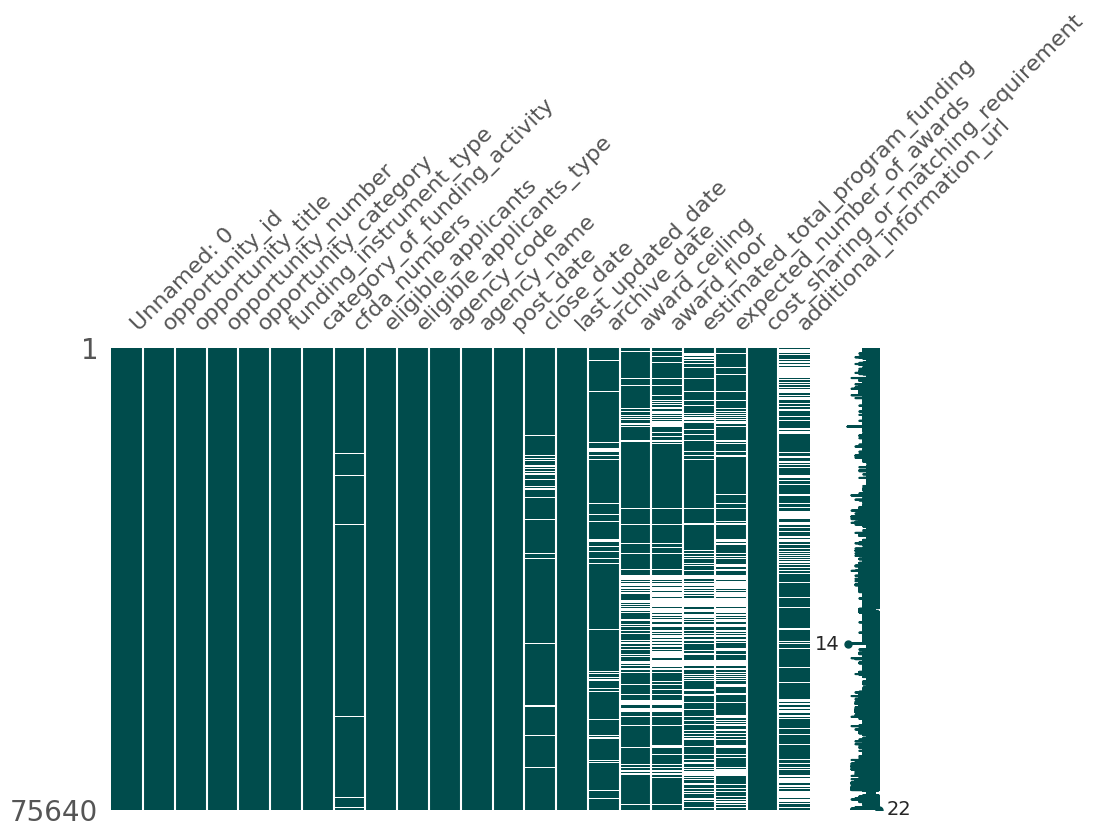

In [162]:
msno.matrix(df, figsize=(10,6), color=(0,.3,.3))

In [163]:
df = df.drop("opportunity_id", axis=1)

df["post_date"] = pd.to_datetime(df["post_date"])
df["close_date"] = pd.to_datetime(df["close_date"])
df["last_updated_date"] = pd.to_datetime(df["last_updated_date"])
df["archive_date"] = pd.to_datetime(df["archive_date"])

df["post_year"] = pd.to_datetime(df["post_date"].dt.strftime("%Y"))
df["estimated_total_program_funding"] = df.apply(
    lambda x: x["estimated_total_program_funding"]
    if x["estimated_total_program_funding"] != None and x["estimated_total_program_funding"] != 0
    else x["award_ceiling"] * x["expected_number_of_awards"],
    axis=1
)
df["fund_per_award"] = df.apply(
    lambda x: np.nan
    if x["estimated_total_program_funding"] < 1 or x["expected_number_of_awards"] < 1
    else x["estimated_total_program_funding"] / x["expected_number_of_awards"],
    axis=1,
)

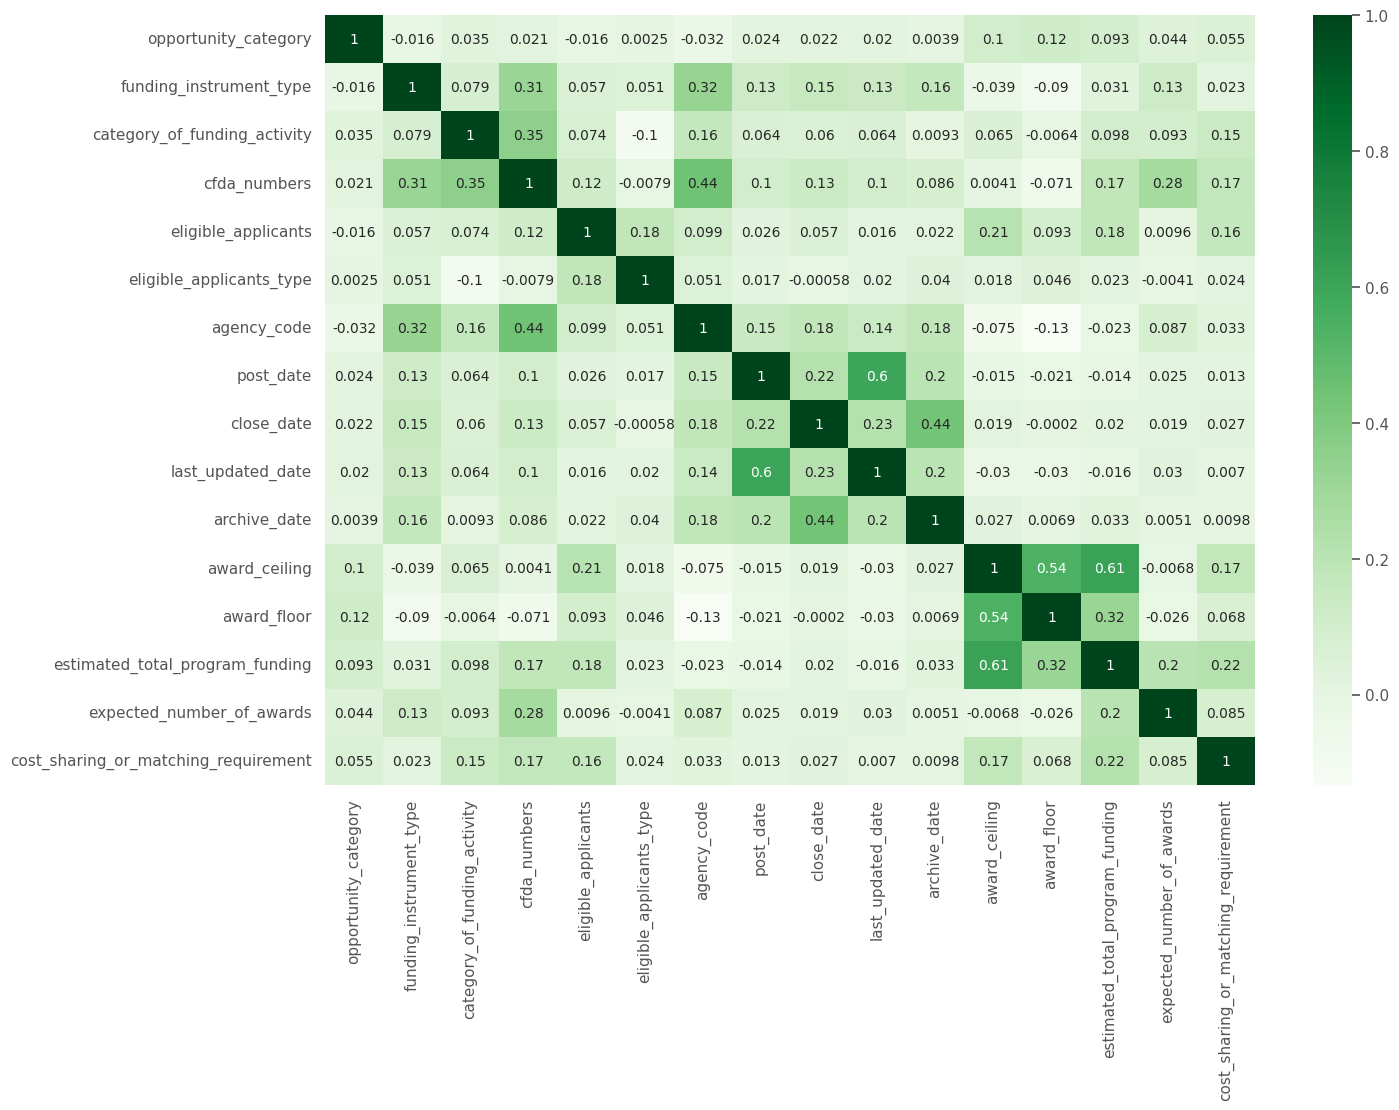

In [164]:
corr_df = df[[
        "opportunity_category", "funding_instrument_type", "category_of_funding_activity",
        "cfda_numbers", "eligible_applicants", "eligible_applicants_type", "agency_code",
        "post_date", "close_date", "last_updated_date", "archive_date", "award_ceiling", "award_floor",
        "estimated_total_program_funding", "expected_number_of_awards", "cost_sharing_or_matching_requirement",
    ]]

plt.figure(figsize=(15,10))
sns.heatmap(corr_df.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1),annot=True, cmap="Greens")
plt.show()

# Instrument Type Distribution

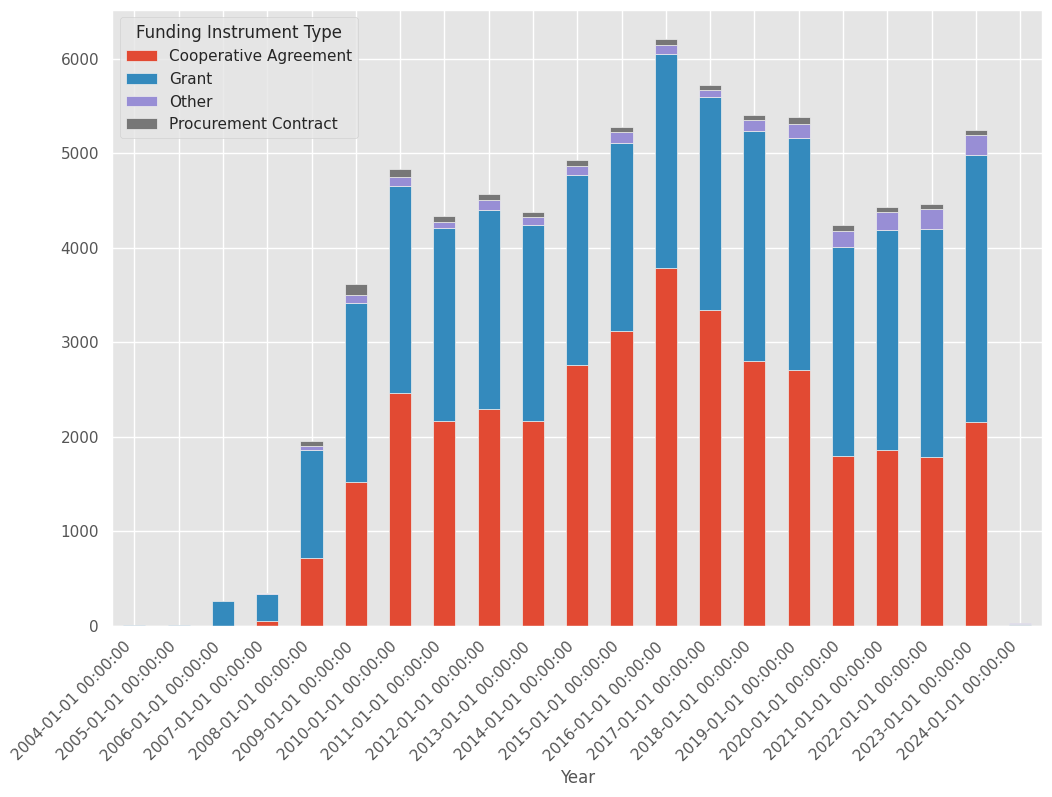

In [165]:
# Pie chart for funding instrument type distribution
fig = px.pie(df, names='funding_instrument_type', title='Funding Instrument Type Distribution')
fig.show()
fi_year_df = df.groupby(["post_year", "funding_instrument_type"]).size().unstack()
plot_year_stack(fi_year_df, "Funding Instrument Type")

# Opportunity Titles WOrd Cloud

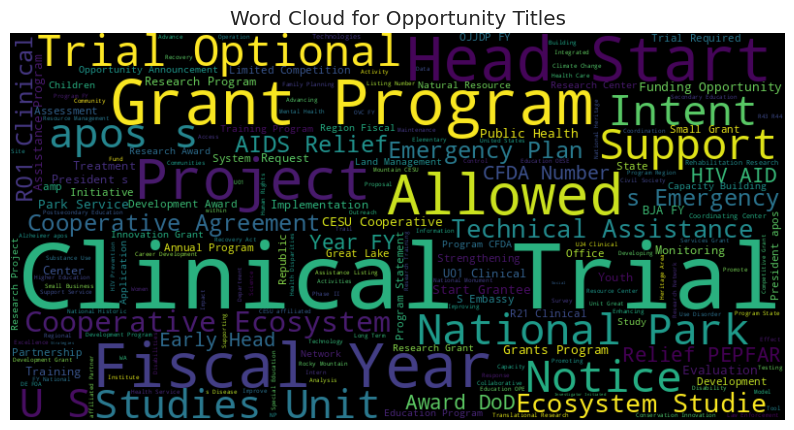

In [166]:
# Word Cloud for Opportunity Titles
wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110).generate(' '.join(df['opportunity_title']))
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Word Cloud for Opportunity Titles")
plt.show()

# Top 10 Agencies By Number Of Opportunities

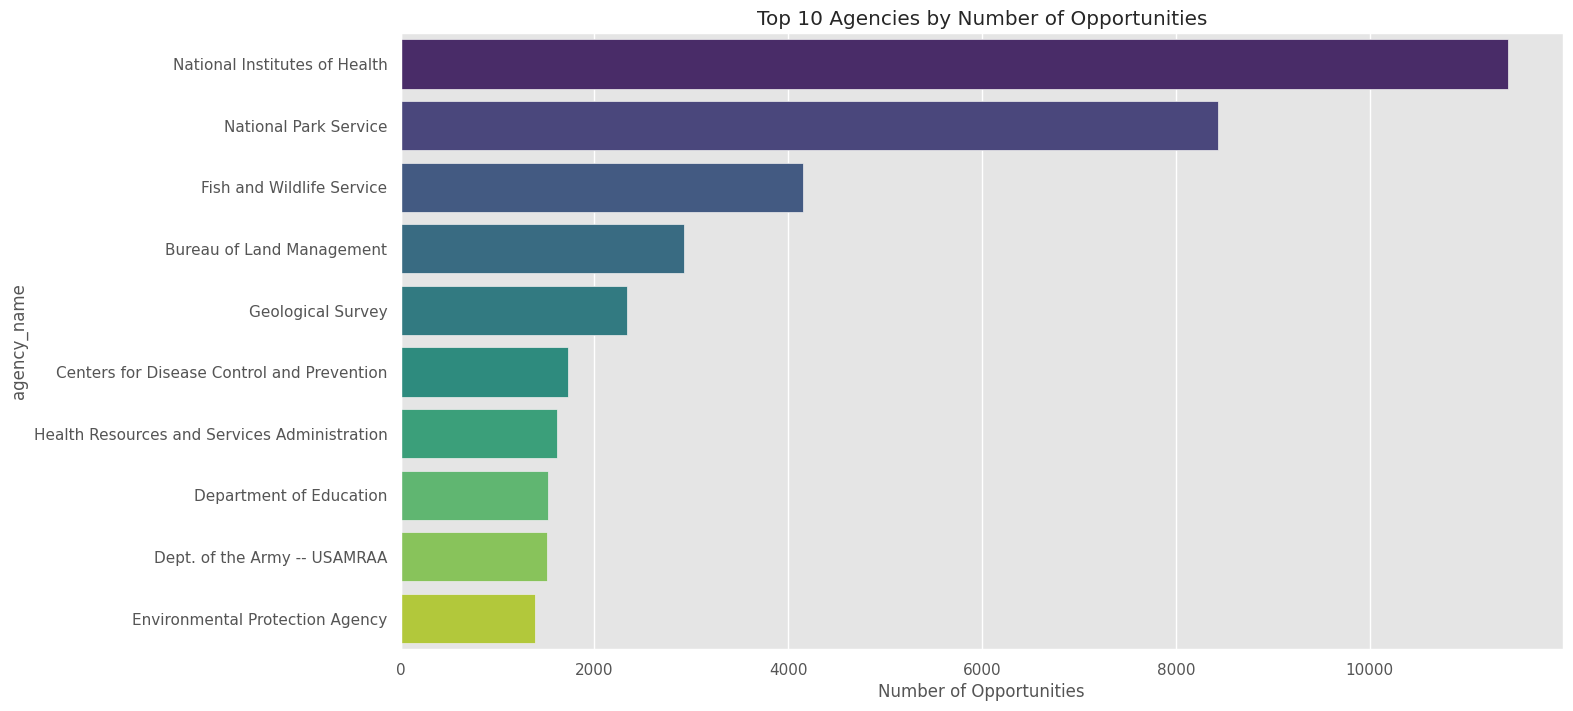

In [167]:
# Bar chart for top 10 agencies by number of opportunities
top_agencies = df['agency_name'].value_counts().nlargest(10)
plt.figure(figsize=(15, 8))
sns.barplot(x=top_agencies.values, y=top_agencies.index, palette='viridis')
plt.title("Top 10 Agencies by Number of Opportunities")
plt.xlabel("Number of Opportunities")
plt.show()

# Grant Amount By Eligible Applicant Type

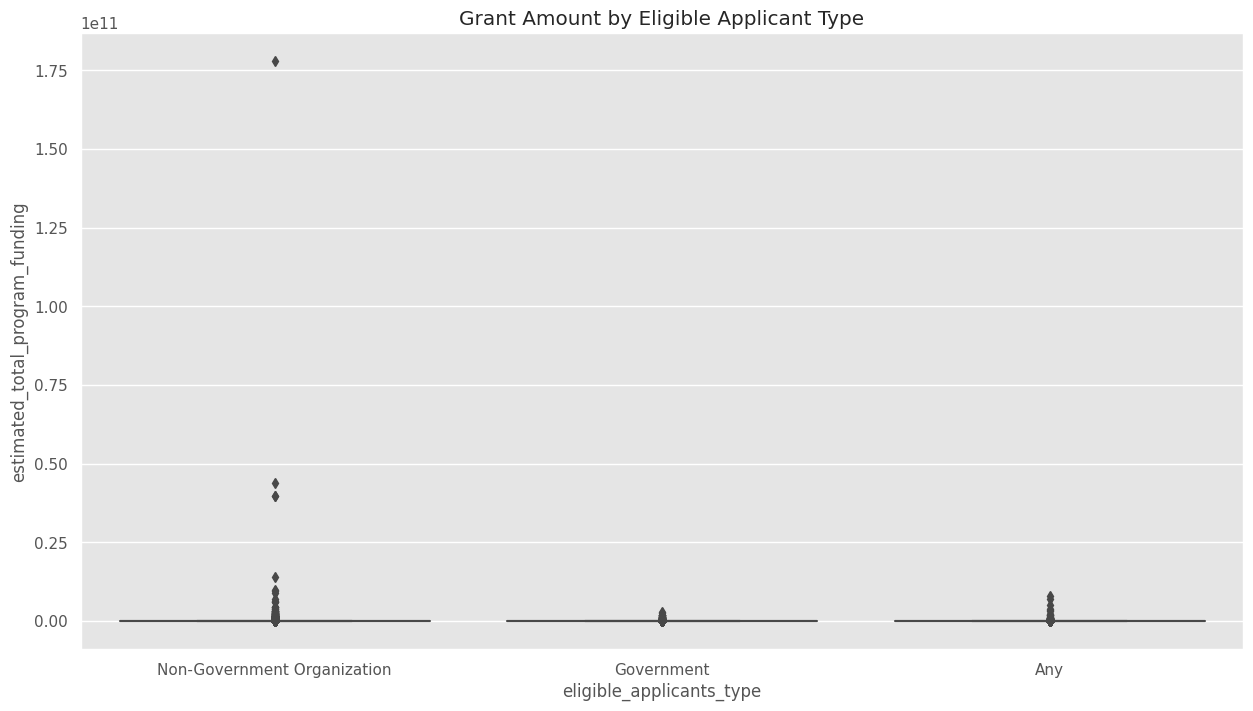

In [168]:
# Boxplot for grant amount by eligible applicant type
plt.figure(figsize=(15, 8))
sns.boxplot(x='eligible_applicants_type', y='estimated_total_program_funding', data=df)
plt.title("Grant Amount by Eligible Applicant Type")
plt.show()


# Number Of Opportunities Posted Over Time

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



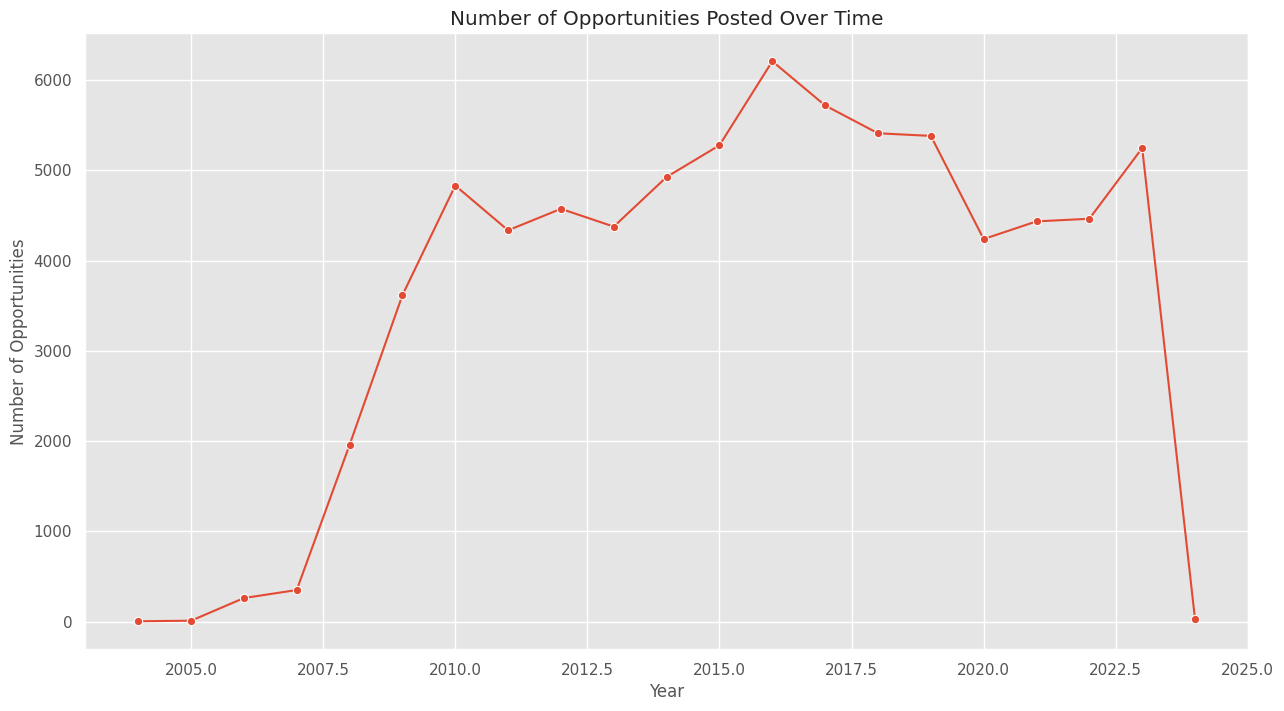

In [169]:
# Time series plot for the number of opportunities posted over time
df['post_date'] = pd.to_datetime(df['post_date'])
df['close_date'] = pd.to_datetime(df['close_date'])
df['last_updated_date'] = pd.to_datetime(df['last_updated_date'])
df['archive_date'] = pd.to_datetime(df['archive_date'])
df['post_year'] = df['post_date'].dt.year
opportunities_over_time = df['post_year'].value_counts().sort_index()
plt.figure(figsize=(15, 8))
sns.lineplot(x=opportunities_over_time.index, y=opportunities_over_time.values, marker='o')
plt.title("Number of Opportunities Posted Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Opportunities")
plt.show()

# Total Funds per Year by Eligible Applicants

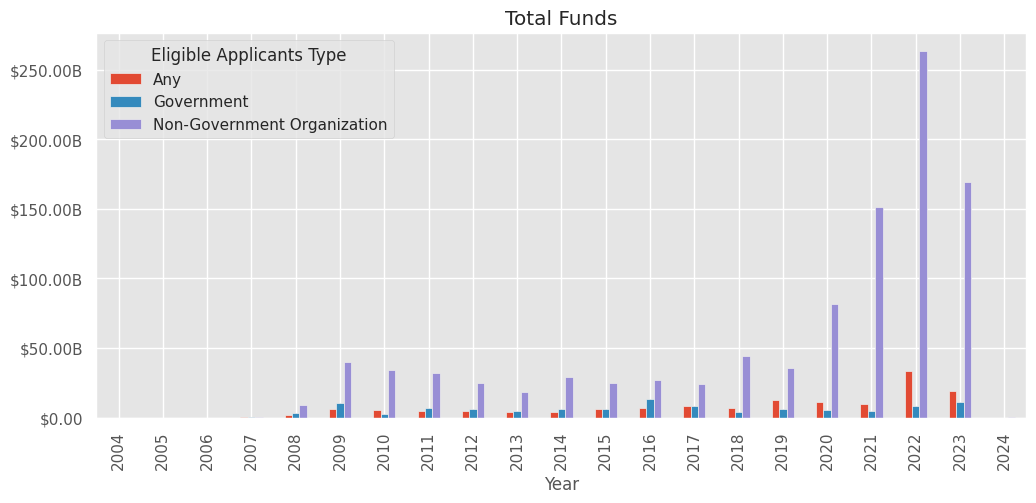

In [170]:
total_fund_df = (
    df.groupby(["post_year", "eligible_applicants_type"])["estimated_total_program_funding"]
    .sum()
    .to_frame("total_funding_per_year")
    .reset_index()
)
total_fund_df = total_fund_df.pivot(index="post_year", columns="eligible_applicants_type", values="total_funding_per_year")
fig, ax = plt.subplots(figsize=(12,5))
total_fund_df.plot(kind="bar", ax=ax)
ax.yaxis.set_major_formatter(comma_formatter) 
ax.legend(title="Eligible Applicants Type")
ax.yaxis.set_major_formatter(human_formatter) 
plt.xlabel("Year")
plt.title("Total Funds")
plt.show()

# Total Cumulative Funds

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



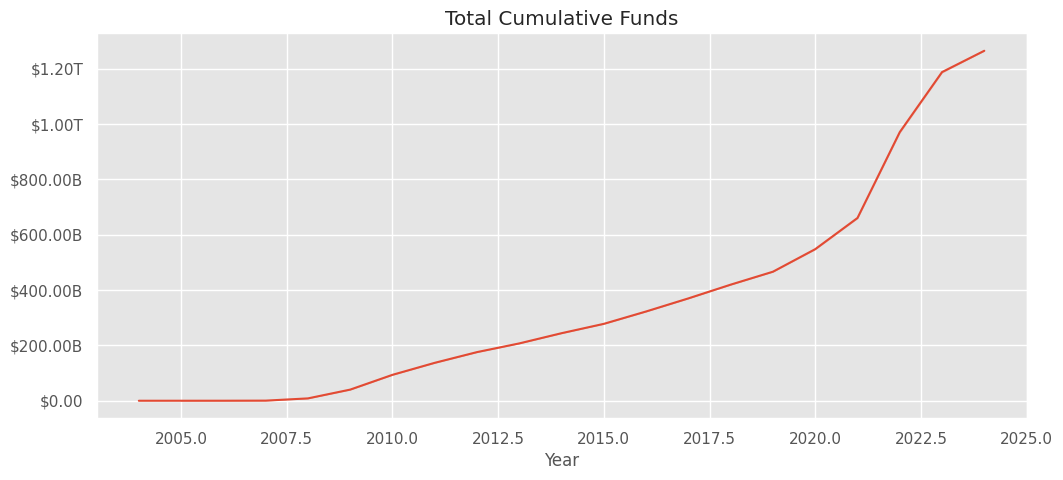

In [171]:
cumsum_fund_df = df.sort_values("post_year")[["post_year", "estimated_total_program_funding"]]
cumsum_fund_df["cumsum_fund"] = cumsum_fund_df["estimated_total_program_funding"].cumsum()
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(ax = ax, data = cumsum_fund_df, x = 'post_year', y = 'cumsum_fund')
ax.yaxis.set_major_formatter(human_formatter) 
plt.xlabel("Year")
plt.ylabel("")
plt.title("Total Cumulative Funds")
plt.show()

# Average Fund per Award

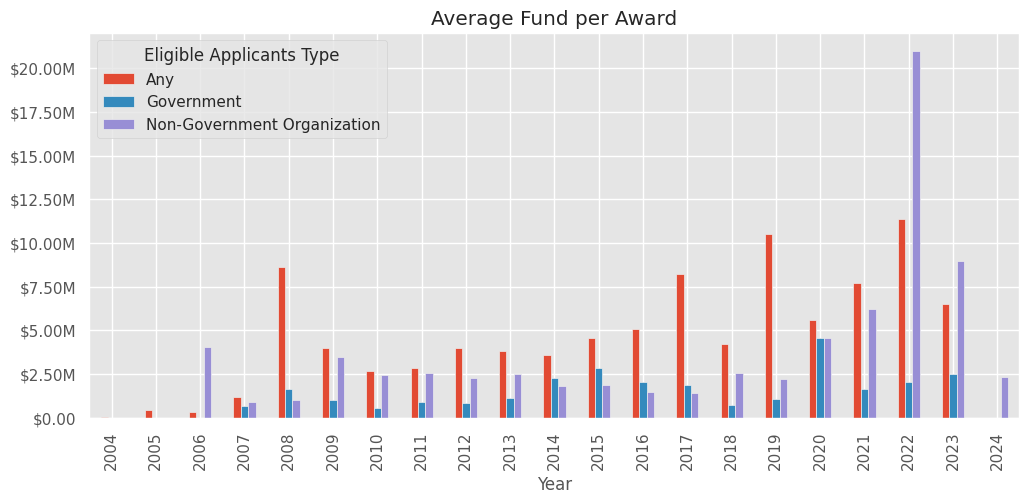

In [172]:
fpa_df = (
    df.groupby(["post_year", "eligible_applicants_type"])["fund_per_award"]
    .mean()
    .to_frame("avg_fund_per_award_per_year")
    .reset_index()
)
fpa_df = fpa_df.pivot(index="post_year", columns="eligible_applicants_type", values="avg_fund_per_award_per_year")
fig, ax = plt.subplots(figsize=(12,5))
fpa_df.plot(kind="bar", ax=ax)
ax.legend(title="Eligible Applicants Type")
ax.yaxis.set_major_formatter(human_formatter) 
plt.title("Average Fund per Award")
plt.xlabel("Year")
plt.show()

# Eligible Applicants Type Breakdown

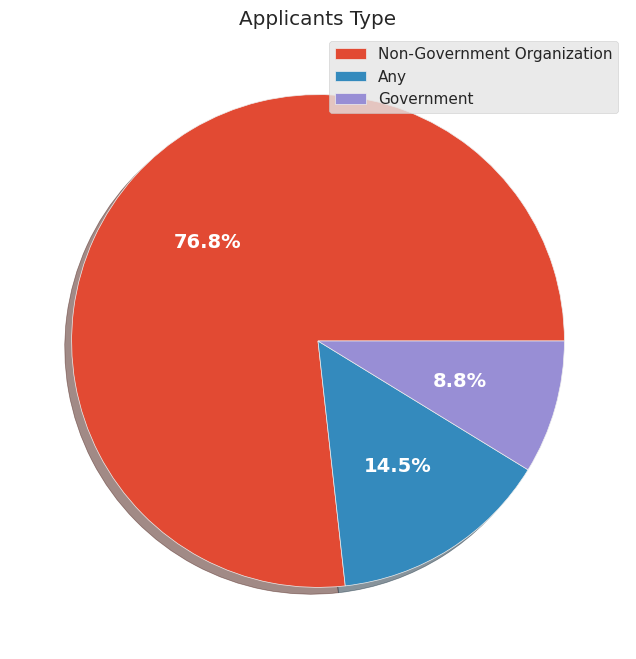

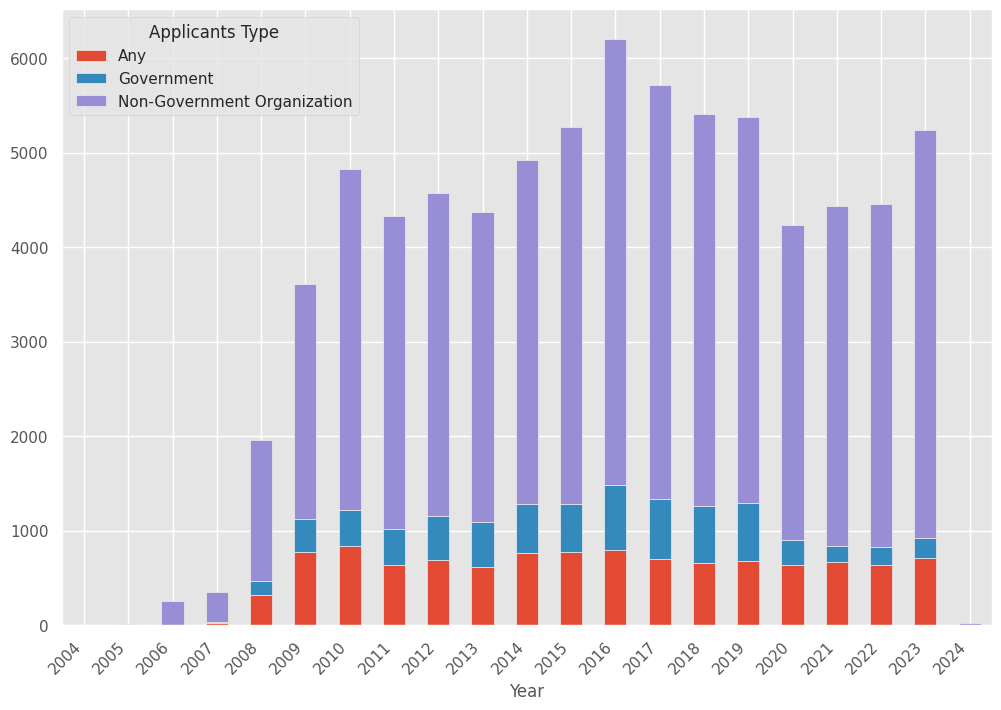

In [173]:
plot_pie(df, "eligible_applicants_type", "Applicants Type")
ea_year_df = df.groupby(["post_year", "eligible_applicants_type"]).size().unstack()
plot_year_stack(ea_year_df, "Applicants Type")

# Opportunity Category Breakdown

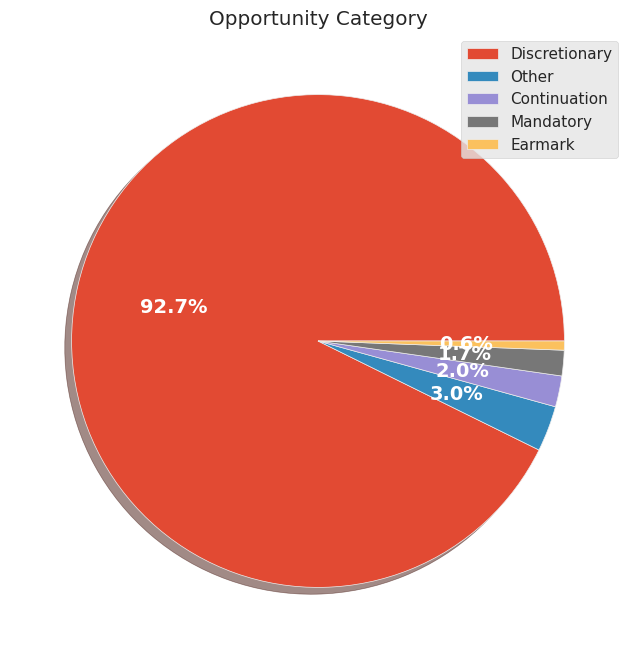

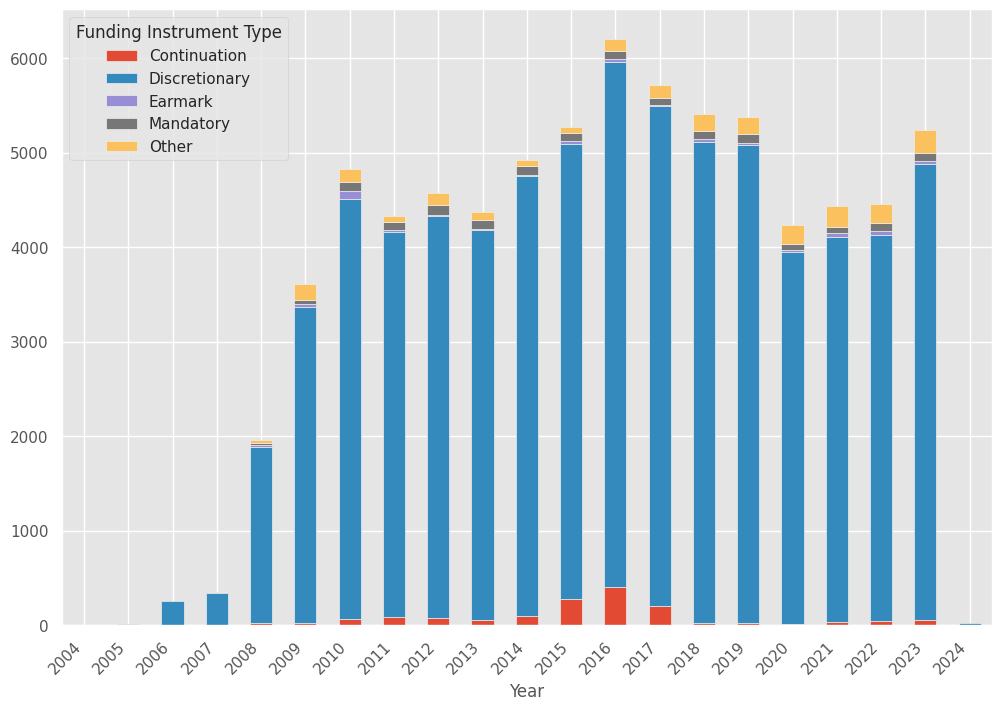

In [174]:
plot_pie(df, "opportunity_category", "Opportunity Category")
oc_year_df = df.groupby(["post_year", "opportunity_category"]).size().unstack()
plot_year_stack(oc_year_df, "Funding Instrument Type")

# Top 20 Frequently Funding Agency

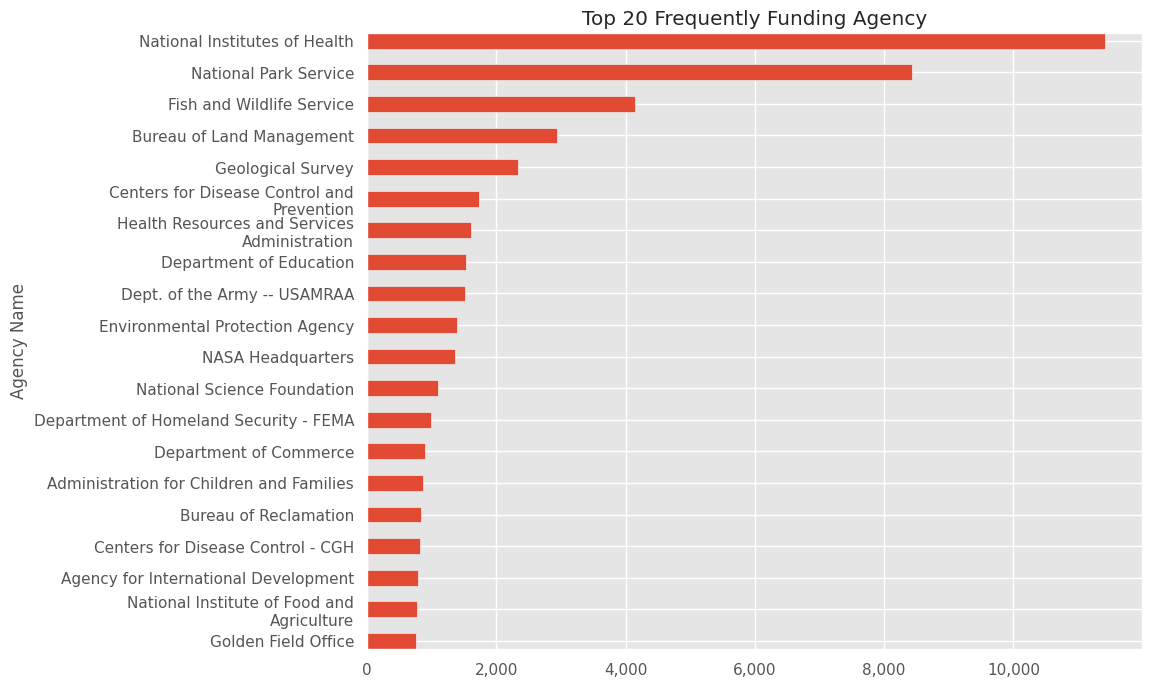

In [175]:
agency_count_df = (
    df.groupby("agency_name")
    .size()
    .to_frame("size").reset_index()
    .sort_values("size", ascending=False)
    .head(20)
)
ax = plot_barh(agency_count_df, "agency_name", "Top 20 Frequently Funding Agency", "Agency Name")
ax.xaxis.set_major_formatter(comma_formatter) 
plt.show()


# Top 20 High Budget Funding Agency

/tmp/ipykernel_234/2985260339.py:3: FutureWarning:

The provided callable <function sum at 0x799c740ae0e0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.



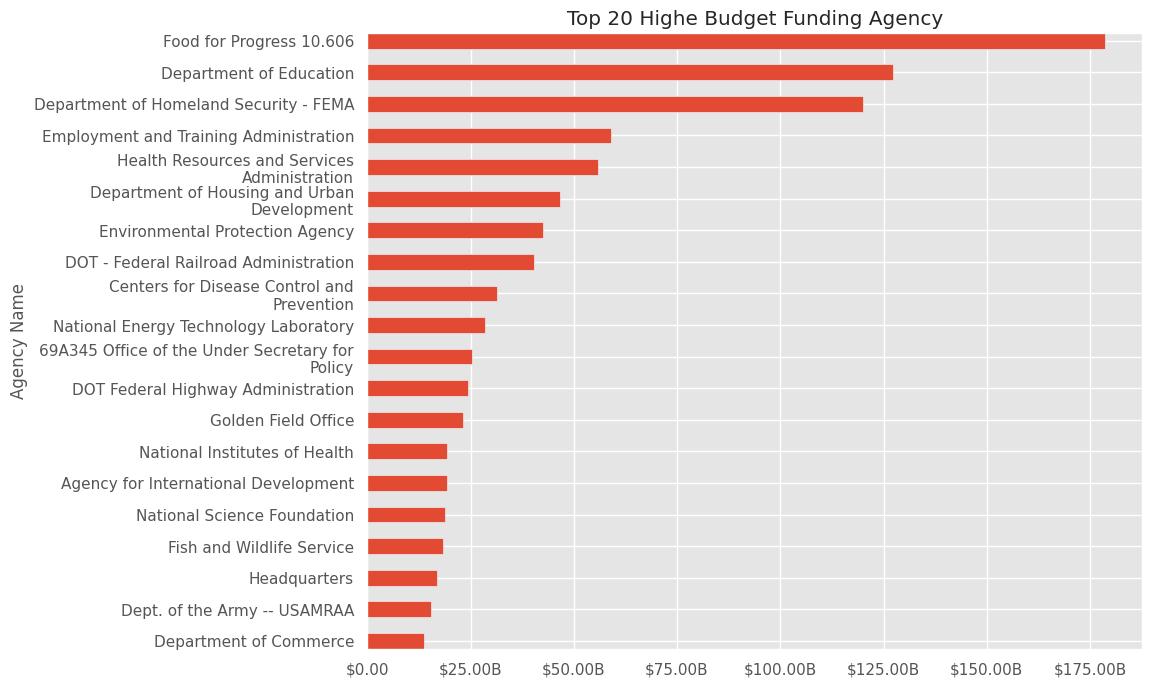

In [176]:
agency_fund_df = (
    df.groupby("agency_name")["estimated_total_program_funding"]
    .agg([np.sum])
    .sort_values("sum", ascending=False)
    .reset_index()
    .head(20)
)
ax = plot_barh(agency_fund_df, "agency_name", "Top 20 Highe Budget Funding Agency", "Agency Name")
ax.xaxis.set_major_formatter(human_formatter)
plt.show()

# Number of Awards Count

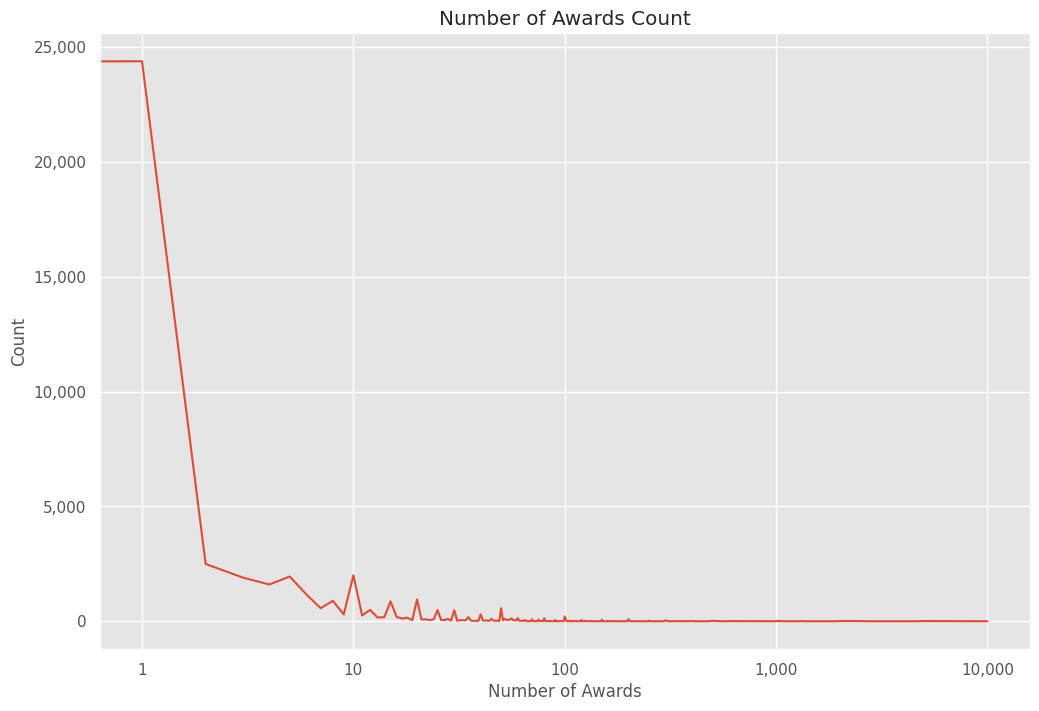

In [177]:
award_df = df[
    (np.abs(stats.zscore(df["expected_number_of_awards"], nan_policy='omit')) < 0.01)
    & (np.abs(stats.zscore(df["estimated_total_program_funding"], nan_policy='omit')) < 1)
]
ax = award_df.groupby("expected_number_of_awards").size().plot(
    figsize=(12, 8),
)
ax.set_xlabel("Number of Awards")
ax.set_ylabel("Count")
ax.set_xscale("log")
ax.xaxis.set_major_formatter(comma_formatter)
ax.yaxis.set_major_formatter(comma_formatter)
plt.title("Number of Awards Count")
plt.show()

# Average Enrollment Days per Year

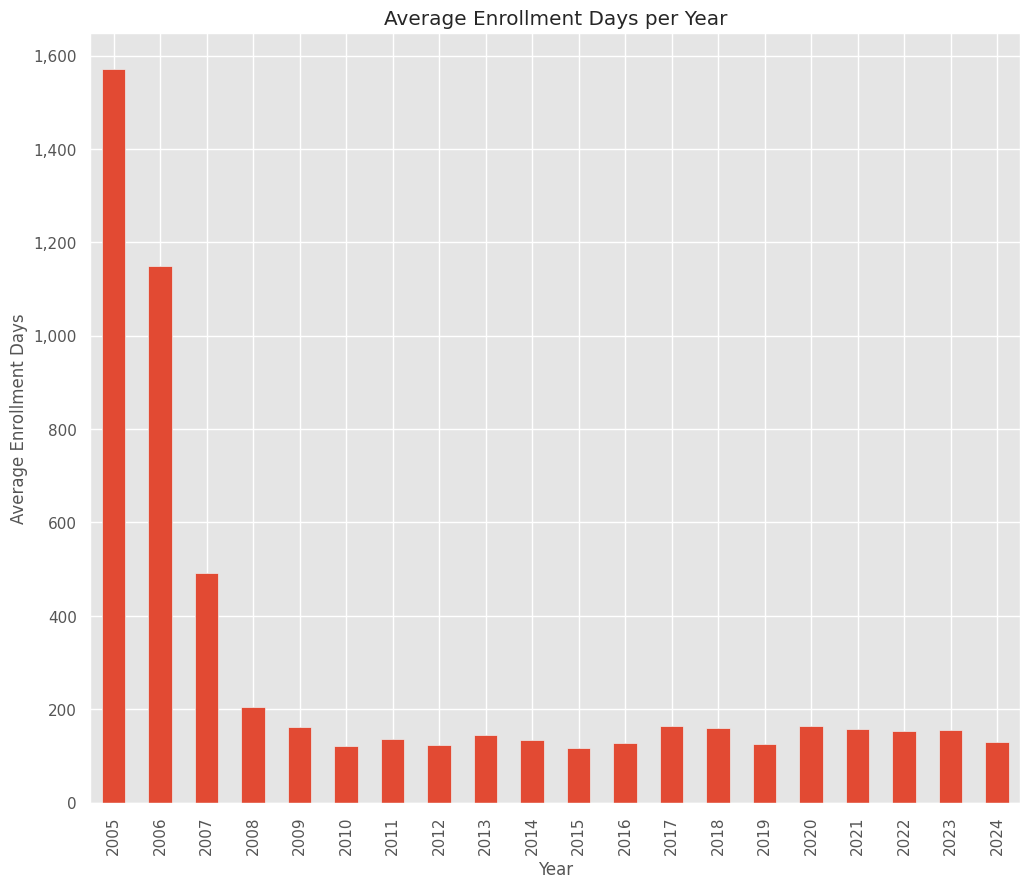

In [178]:
df["open_days"] = (df["close_date"] - df["post_date"]).dt.days
open_days_df = df[(df["open_days"].notna()) & (df["open_days"] < 10000)]
open_days_df = open_days_df.groupby("post_year")["open_days"].mean().to_frame("mean_open_days").reset_index()
ax = open_days_df.plot(kind="bar", x="post_year", y="mean_open_days", figsize=(12, 10))
ax.yaxis.set_major_formatter(comma_formatter) 
ax.get_legend().remove()
plt.xlabel("Year")
plt.ylabel("Average Enrollment Days")
plt.title("Average Enrollment Days per Year")
plt.show()

# Funding vs Number of Awards Coorelation

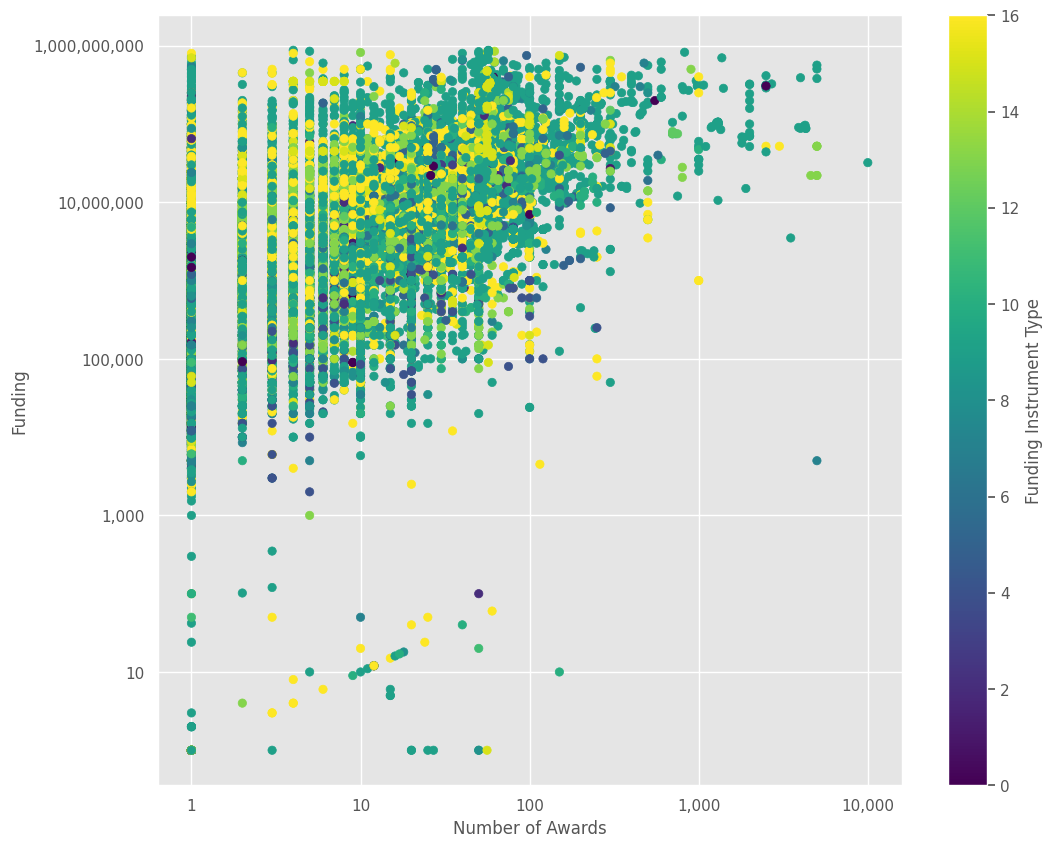

In [179]:
fig, ax = plt.subplots(figsize=(12, 10))
plt.scatter(
    x=award_df["expected_number_of_awards"],
    y=award_df["estimated_total_program_funding"],
    c=award_df["eligible_applicants"].astype('category').cat.codes, cmap='viridis'
)
plt.xlabel("Number of Awards")
plt.ylabel("Funding")
cbar = plt.colorbar()
cbar.set_label("Funding Instrument Type")
ax.set_xscale("log")
ax.set_yscale("log")
ax.xaxis.set_major_formatter(comma_formatter)
ax.yaxis.set_major_formatter(comma_formatter)
plt.show()

# Fund Sponsership Responsibility Share

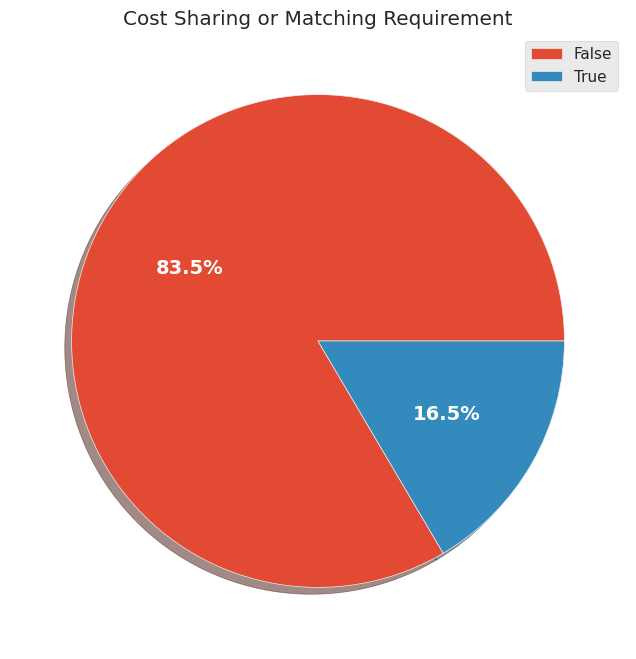

In [180]:
plot_pie(df, "cost_sharing_or_matching_requirement", "Cost Sharing or Matching Requirement")

# Eligible Applicants Breakdown

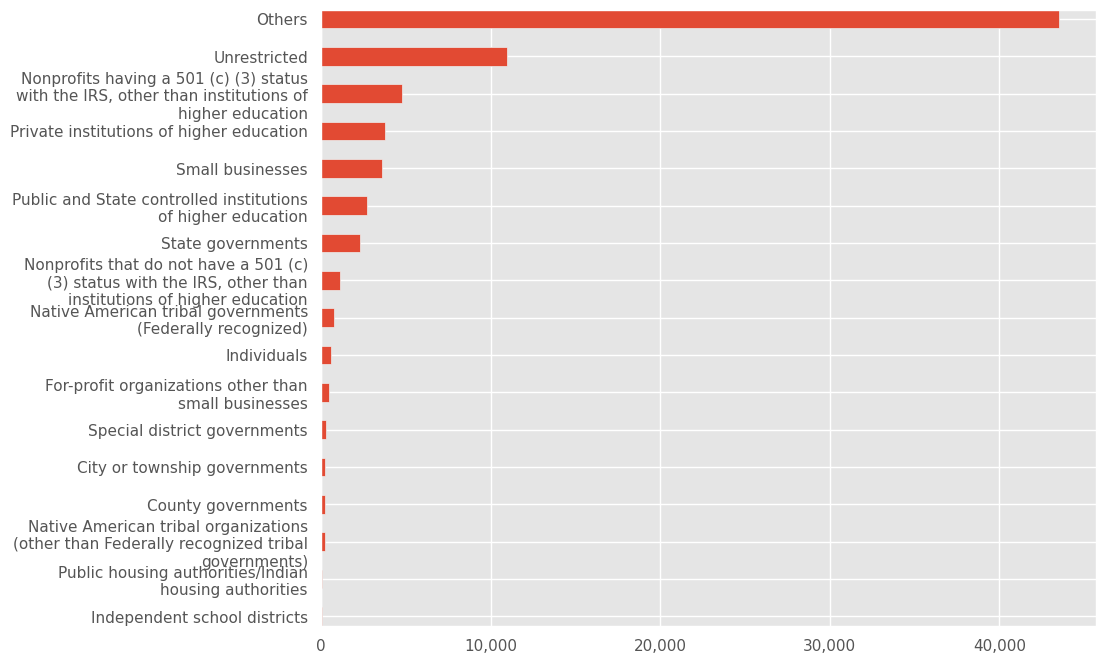

In [ ]:
ea_count_df = (
    df.groupby("eligible_applicants")
    .size()
    .to_frame("size").reset_index()
    .sort_values("size", ascending=False)
)
ax = plot_barh(ea_count_df, "eligible_applicants")
ax.xaxis.set_major_formatter(comma_formatter) 
plt.show()

# Category of Funding Activity Breakdown

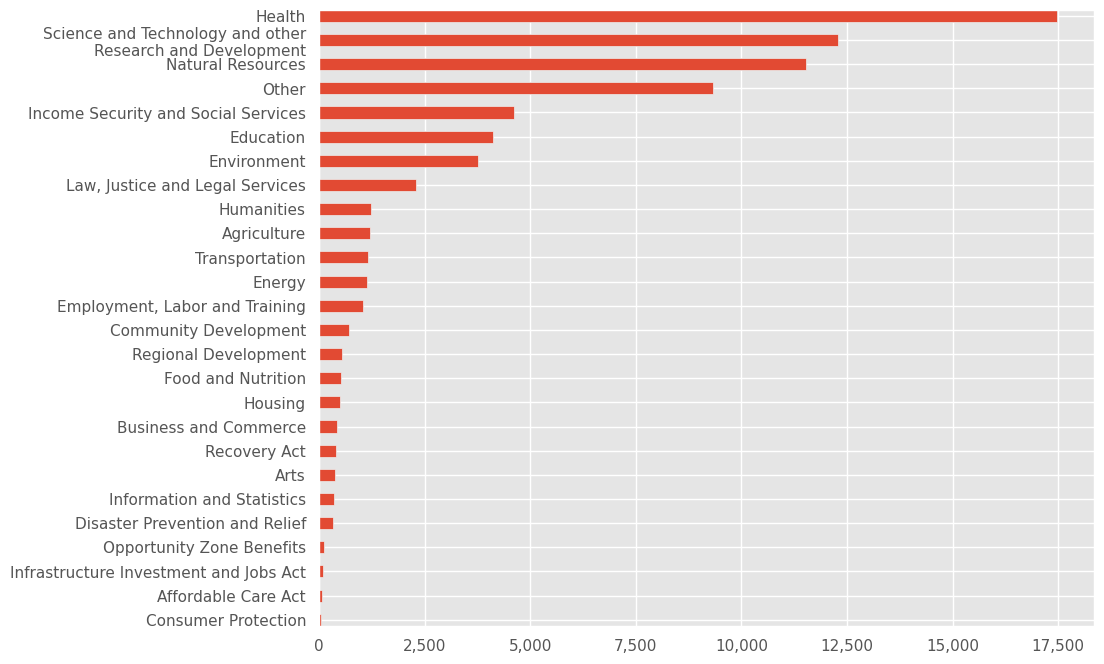

In [182]:
cofa_count_df = (
    df.groupby("category_of_funding_activity")
    .size()
    .to_frame("size").reset_index()
    .sort_values("size", ascending=False)
)
ax = plot_barh(cofa_count_df, "category_of_funding_activity")
ax.xaxis.set_major_formatter(comma_formatter) 
plt.show()

# Fund Ceiling vs Fund Floor

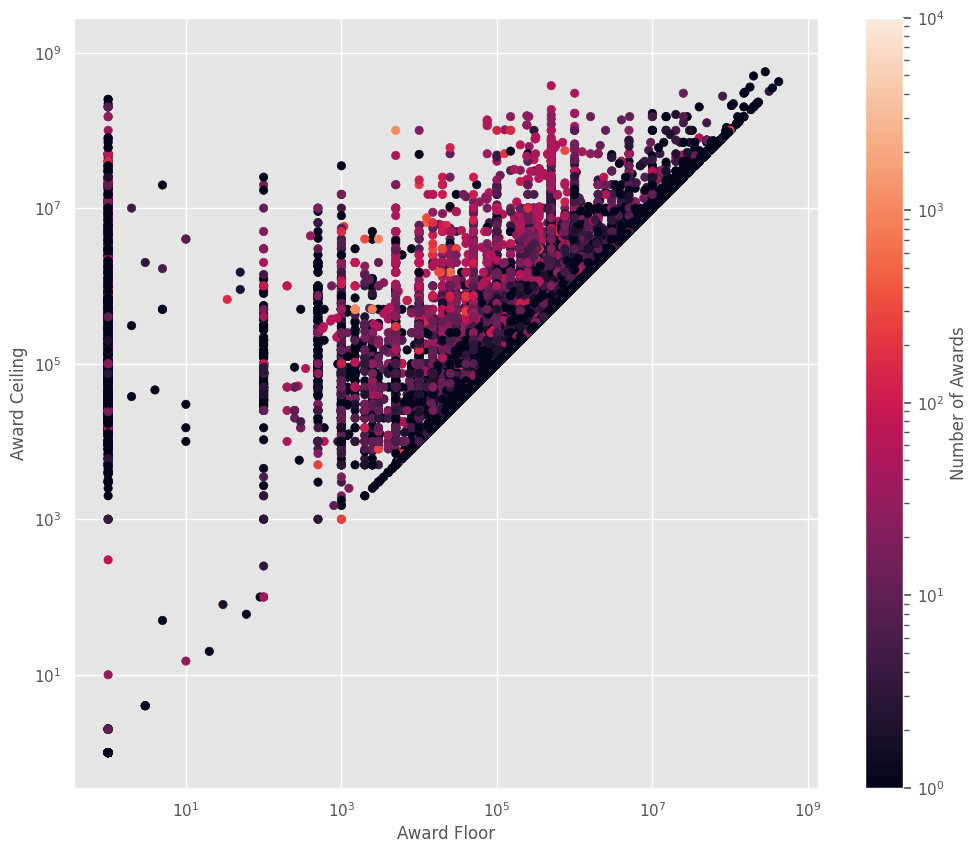

In [183]:
fig, ax = plt.subplots(figsize=(12, 10))
plt.scatter(
    x=award_df["award_floor"],
    y=award_df["award_ceiling"],
    c=award_df["expected_number_of_awards"],
    norm=colors.LogNorm()
)
plt.xlabel("Award Floor")
plt.ylabel("Award Ceiling")
cbar = plt.colorbar()
cbar.set_label("Number of Awards")
ax.set_xscale("log")
ax.set_yscale("log")
plt.show()

# Top Funding Agency URL/Email


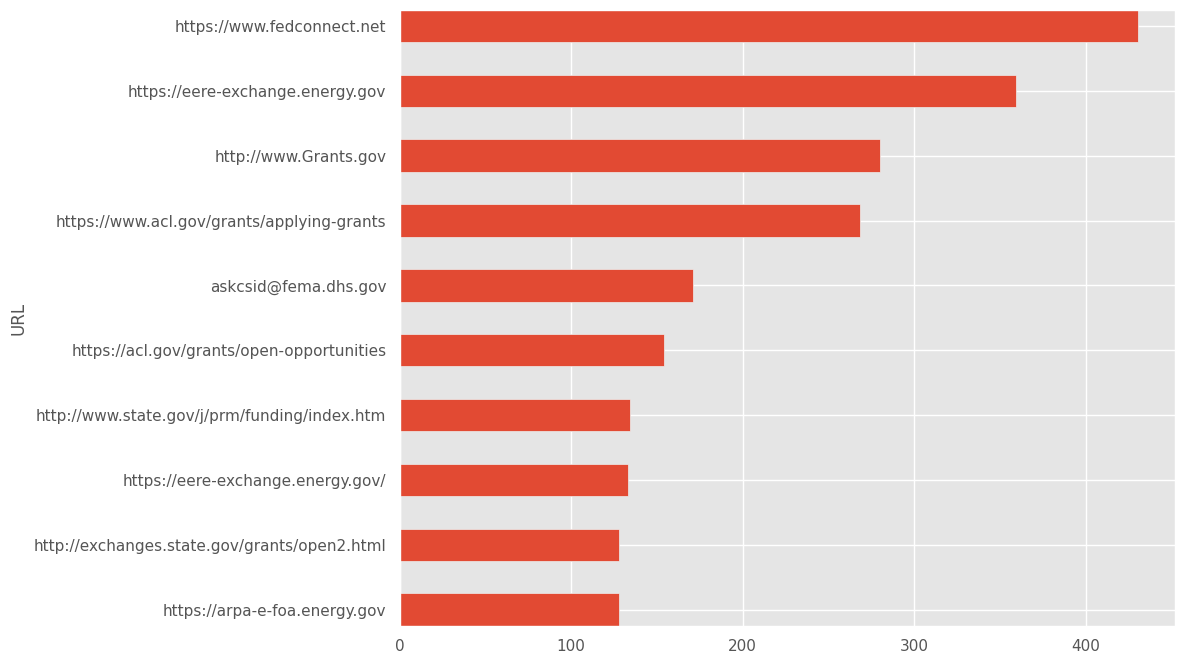

In [184]:
url_df = df[df["additional_information_url"].notna()]
url_df = url_df[~url_df["additional_information_url"].str.contains("grants.gov")]
url_df = url_df[~url_df["additional_information_url"].str.contains("This is not an active link")]

plt.figure(figsize=(10,8))
ax = url_df.value_counts("additional_information_url").head(10).plot.barh()
ax.invert_yaxis()
ax.autoscale(enable=True, axis="y", tight=True)
ax.set_ylabel("URL")
plt.show()

# Funding Instrument Type / Category of Funding Activity

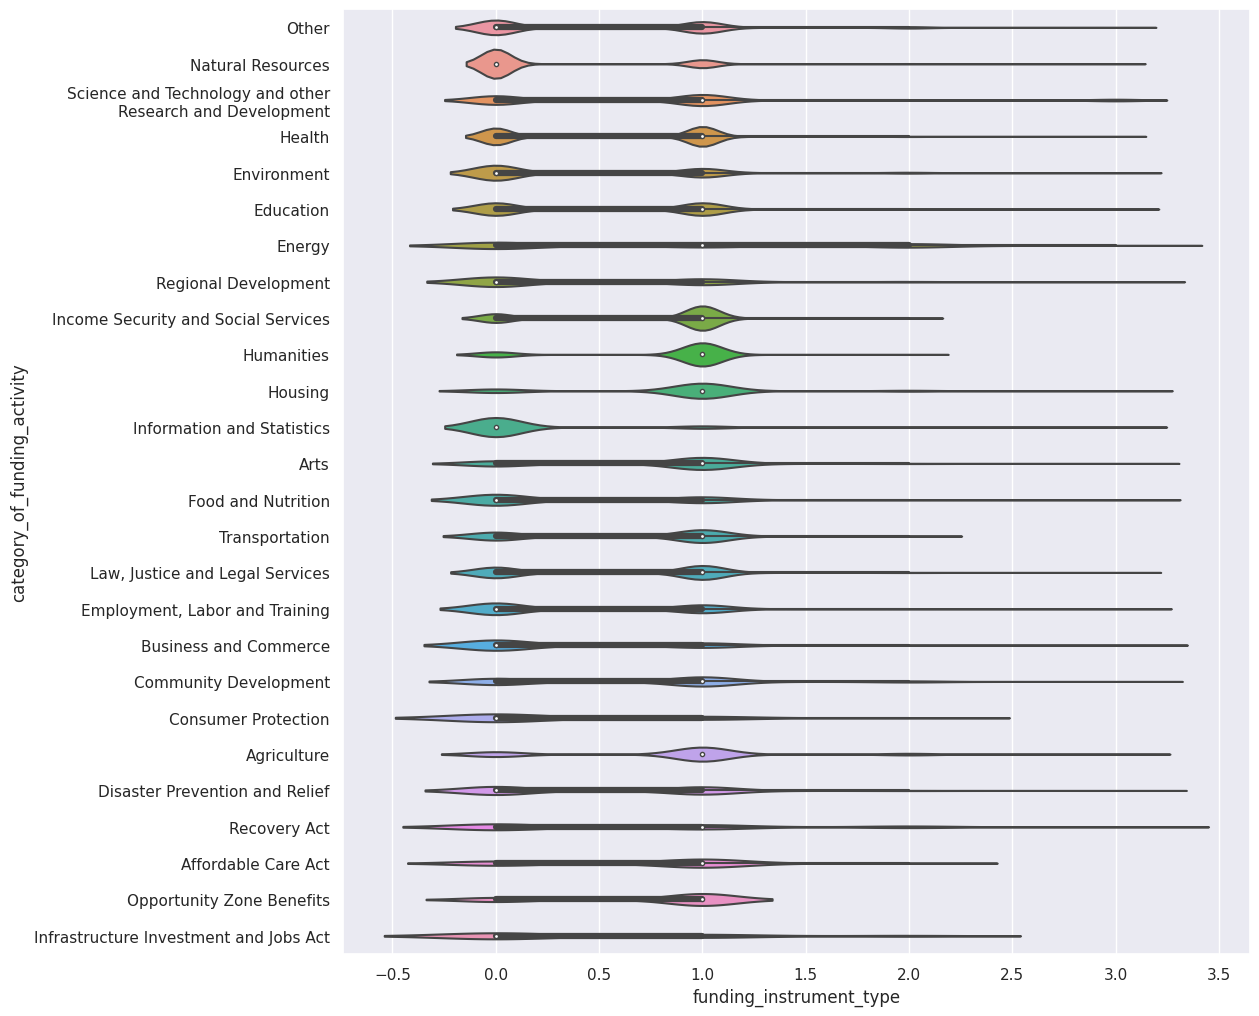

In [185]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['funding_instrument_type'] = label_encoder.fit_transform(df['funding_instrument_type'])
sns.set(rc={'figure.figsize':(11.7,12.27)})
ax = sns.violinplot(data=df, x="funding_instrument_type", y="category_of_funding_activity")
labels = ["\n".join(wrap(l, 40)) for l in df["category_of_funding_activity"].unique()]
ax.set_yticklabels(labels)
plt.show()

# Opportunity Category / Category of Funding Activity

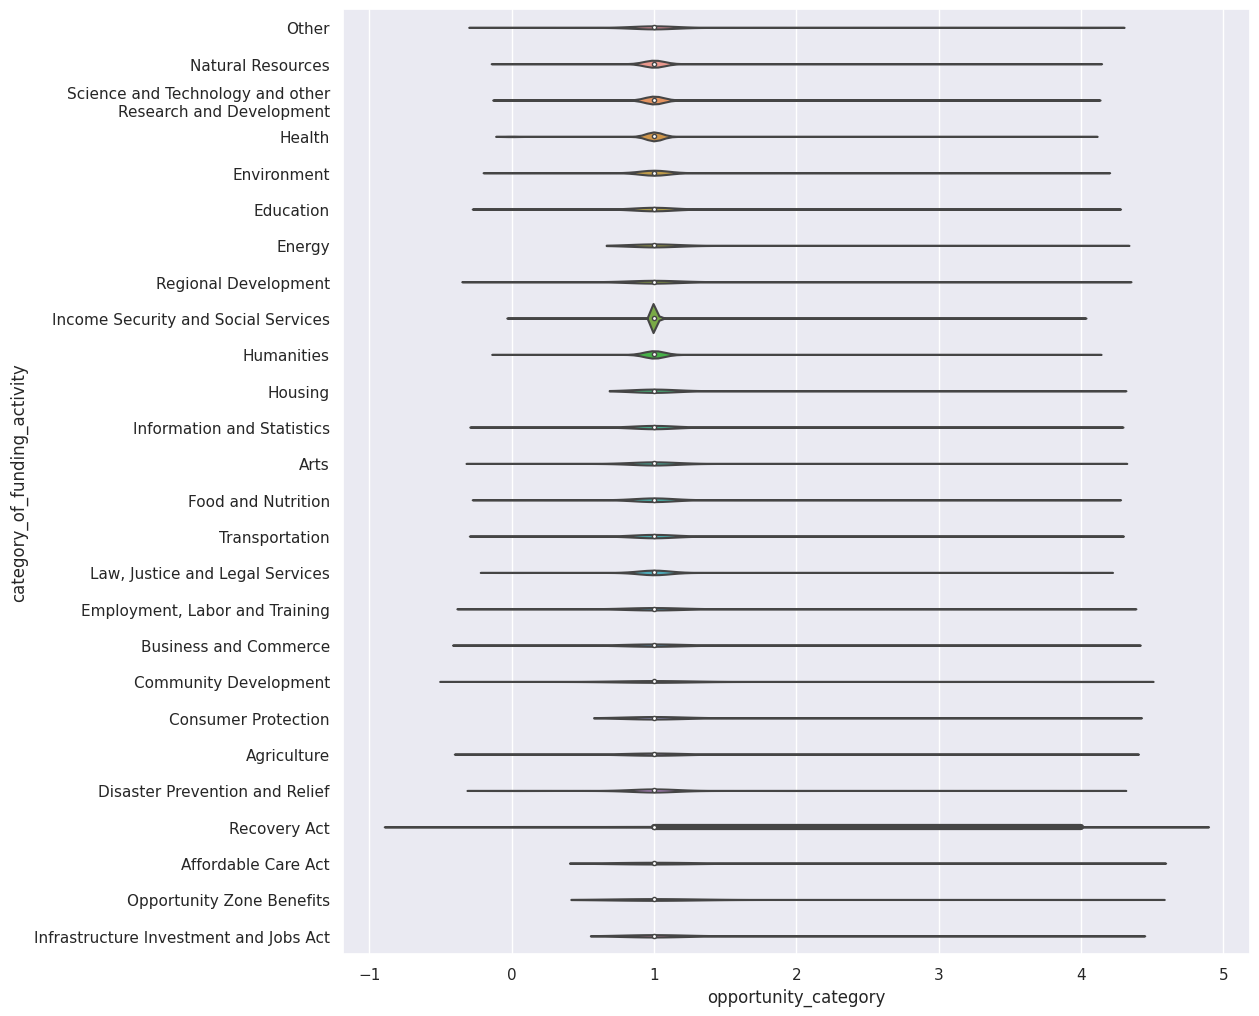

In [186]:
df['opportunity_category'] = label_encoder.fit_transform(df['opportunity_category'])
sns.set(rc={'figure.figsize':(11.7,12.27)})
ax = sns.violinplot(data=df, x="opportunity_category", y="category_of_funding_activity")
labels = ["\n".join(wrap(l, 40)) for l in df["category_of_funding_activity"].unique()]
ax.set_yticklabels(labels)
plt.show()

# Opportunity Category / Eligible Applicants

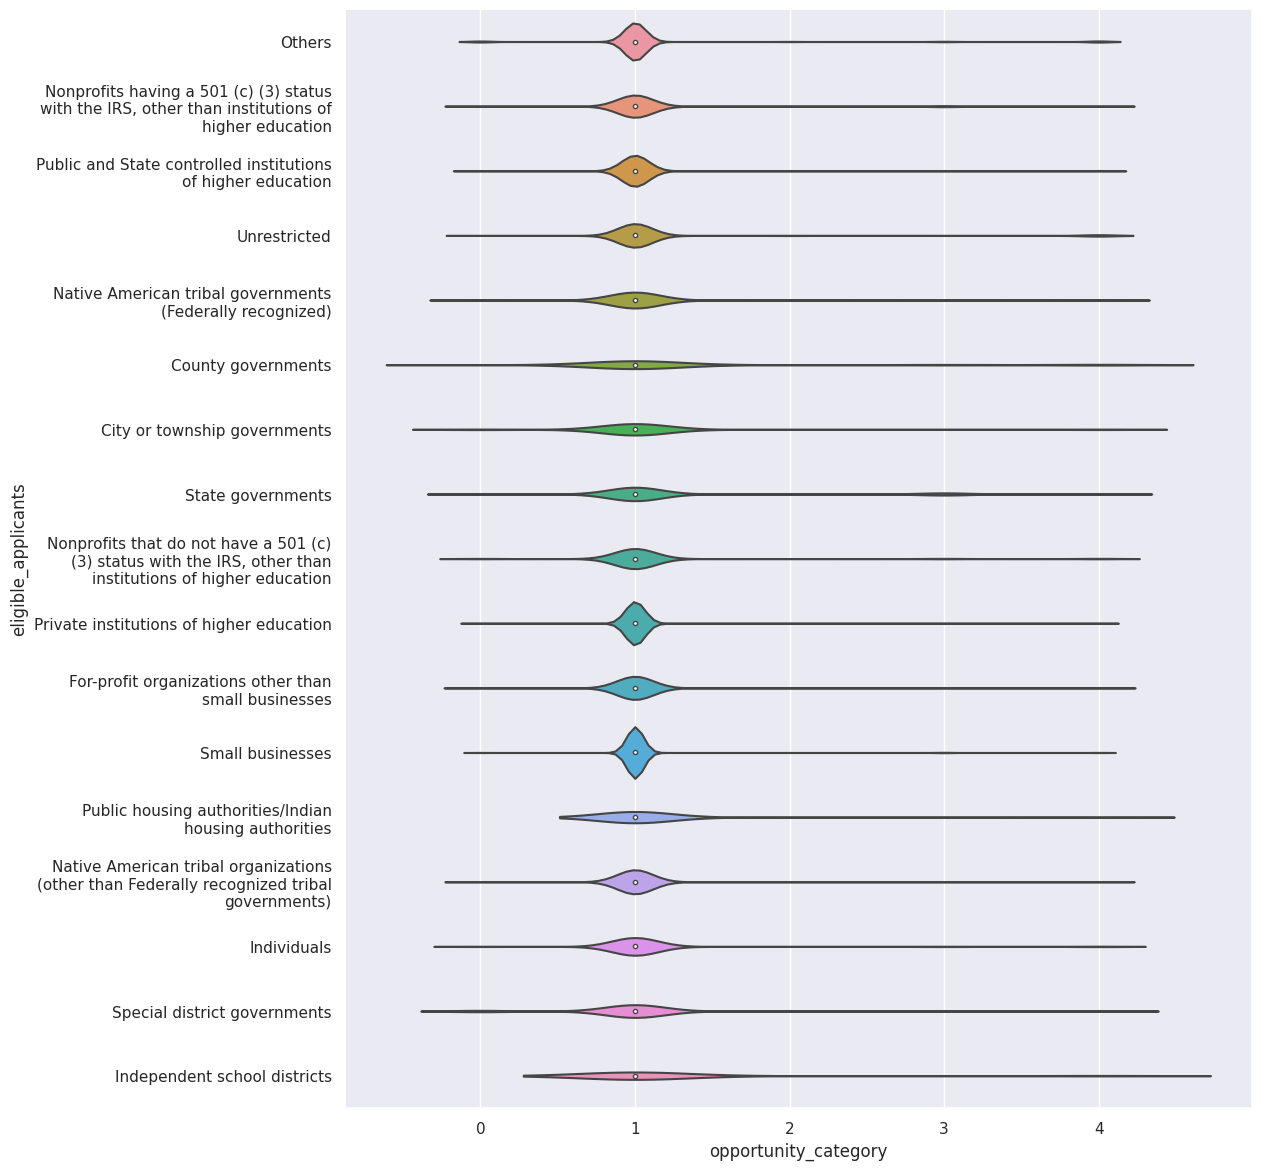

In [187]:
sns.set(rc={'figure.figsize':(11.7,14.27)})
ax = sns.violinplot(data=df, x="opportunity_category", y="eligible_applicants")
labels = ["\n".join(wrap(l, 40)) for l in df["eligible_applicants"].unique()]
ax.set_yticklabels(labels)
plt.show()

# Funding Instrument Type / Eligible Applicants

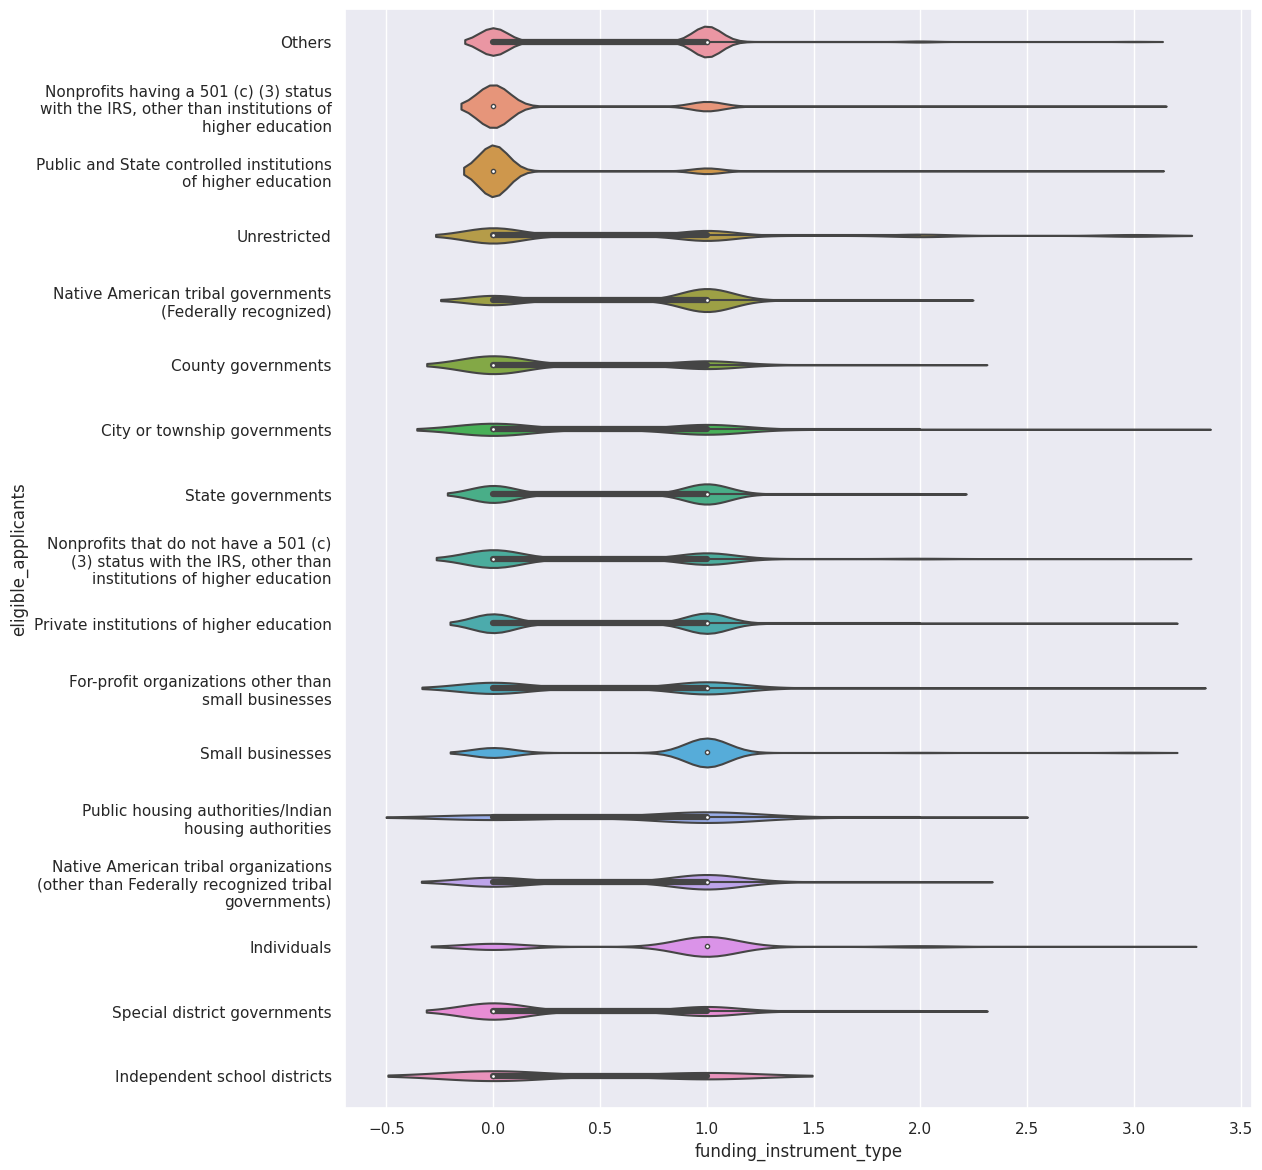

In [188]:
sns.set(rc={'figure.figsize':(11.7,14.27)})
ax = sns.violinplot(data=df, x="funding_instrument_type", y="eligible_applicants")
labels = ["\n".join(wrap(l, 40)) for l in df["eligible_applicants"].unique()]
ax.set_yticklabels(labels)
plt.show()

# Eligible Applicants Type / Eligible Applicants

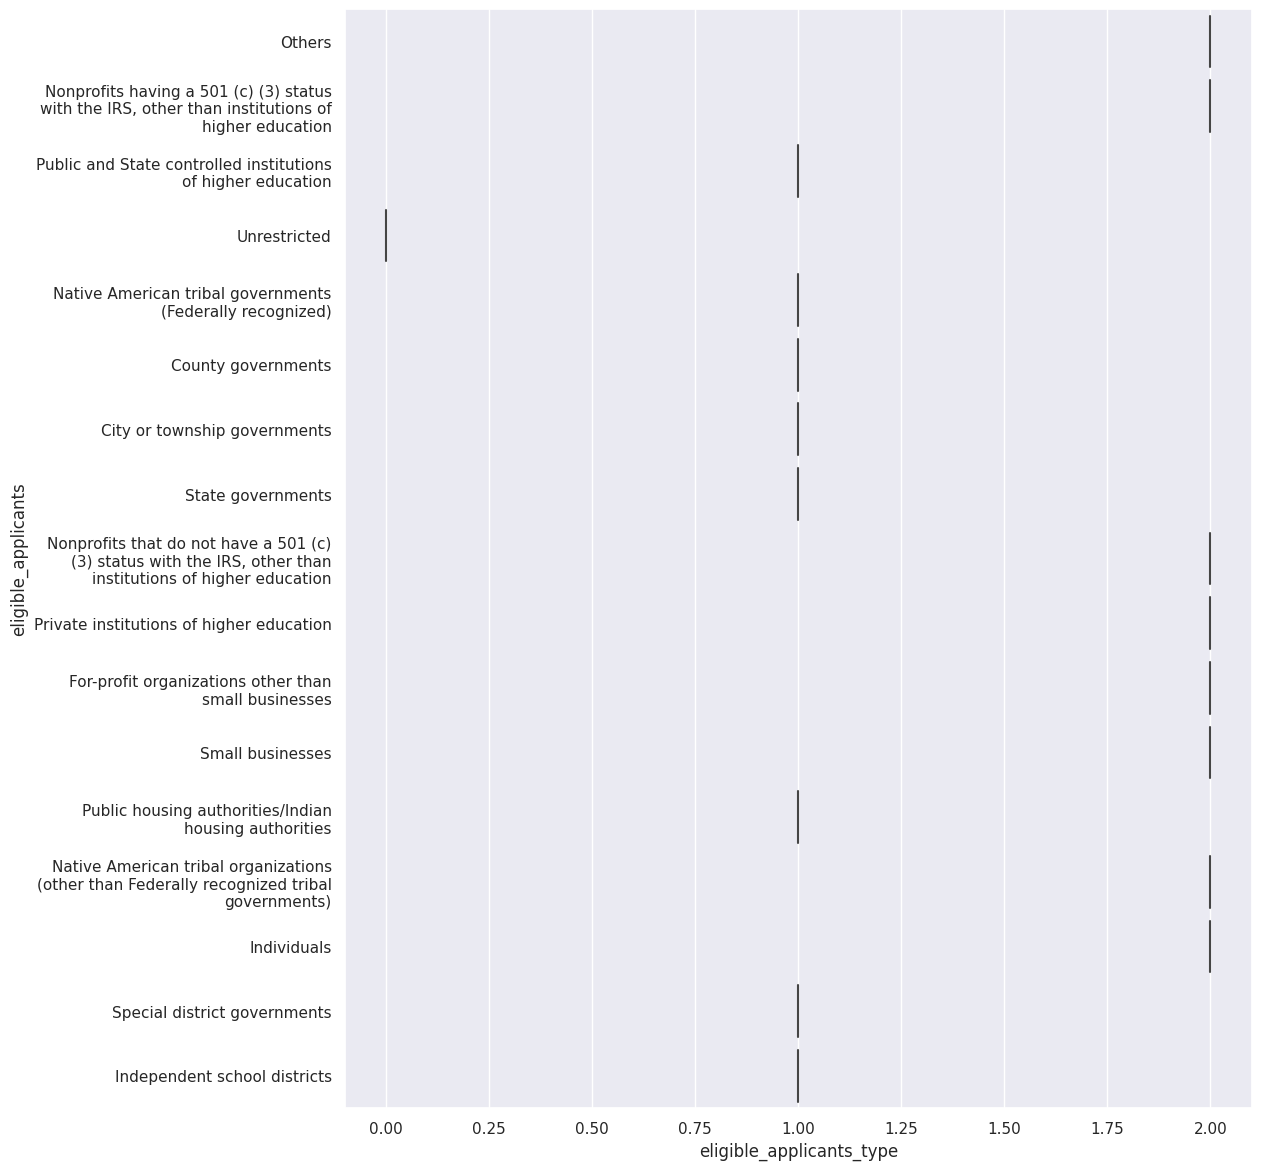

In [189]:
df['eligible_applicants_type'] = label_encoder.fit_transform(df['eligible_applicants_type'])
sns.set(rc={'figure.figsize':(11.7,14.27)})
ax = sns.violinplot(data=df, x="eligible_applicants_type", y="eligible_applicants")
labels = ["\n".join(wrap(l, 40)) for l in df["eligible_applicants"].unique()]
ax.set_yticklabels(labels)
plt.show()

# Data Splitting

In [190]:
# Assuming 'estimated_total_program_funding' is the target variable for regression
X_reg = df[['expected_number_of_awards', 'award_ceiling', 'award_floor']].fillna(0)
y_reg = df['estimated_total_program_funding'].fillna(0)

In [191]:
# Split the data into training and testing sets
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Regression Method

In [192]:
# Initialize models
models_reg = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Support Vector Machine': SVR(),
    'XGBoost': xgb.XGBRegressor(),
    'KNN': KNeighborsRegressor()
}

In [193]:
# Train and evaluate models
regression_results = {}
for name, model in models_reg.items():
    model.fit(X_reg_train, y_reg_train)
    y_reg_pred = model.predict(X_reg_test)
    mse = mean_squared_error(y_reg_test, y_reg_pred)
    r2 = r2_score(y_reg_test, y_reg_pred)
    regression_results[name] = {'Mean Squared Error': mse, 'R^2 Score': r2}

    # Save the trained model
    model_filename = f"{name}_regression_model.joblib"
    joblib.dump(model, model_filename)


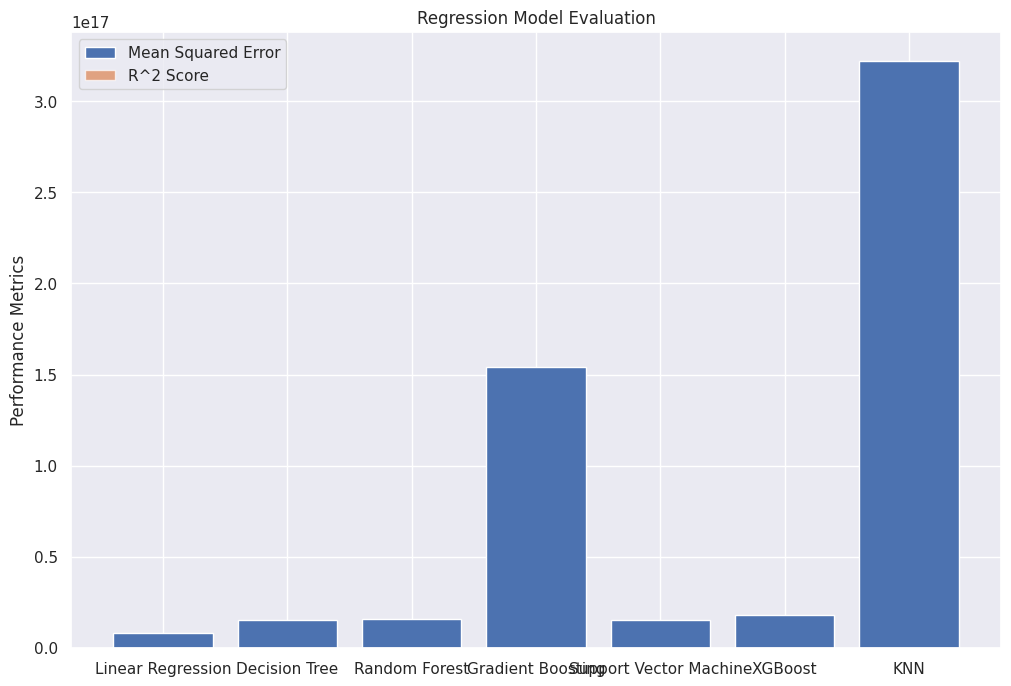

In [194]:
# Plot the results
fig, ax = plt.subplots(figsize=(12, 8))
mse_values = [result['Mean Squared Error'] for result in regression_results.values()]
r2_values = [result['R^2 Score'] for result in regression_results.values()]
ax.bar(regression_results.keys(), mse_values, label='Mean Squared Error')
ax.bar(regression_results.keys(), r2_values, label='R^2 Score', alpha=0.7)
ax.set_title('Regression Model Evaluation')
ax.set_ylabel('Performance Metrics')
ax.legend()
plt.show()

# Splitting for classification Model

In [195]:
# Assuming 'eligible_applicants_type' is the target variable for classification
X_cls = df[['expected_number_of_awards', 'award_ceiling', 'award_floor']].fillna(0)
y_cls = df['eligible_applicants_type'].fillna(0)

# Convert categorical target variable to numerical labels
y_cls = pd.factorize(y_cls)[0]

In [ ]:
# Split the data into training and testing sets
X_cls_train, X_cls_test, y_cls_train, y_cls_test = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)

# Classification

In [197]:
# Initialize models
models_cls = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Support Vector Machine': SVC(),
    'XGBoost': XGBClassifier(),
    'KNN': KNeighborsClassifier()
}

In [198]:
from sklearn.metrics import confusion_matrix
# Train and evaluate models
classification_results = {}
conf_matrices = {}
for name, model in models_cls.items():
    model.fit(X_cls_train, y_cls_train)
    y_cls_pred = model.predict(X_cls_test)
    accuracy = accuracy_score(y_cls_test, y_cls_pred)
    report = classification_report(y_cls_test, y_cls_pred, target_names=df['eligible_applicants_type'].unique(), output_dict=True)
    classification_results[name] = {'Accuracy': accuracy, 'Classification Report': report}

    # Save the trained model
    model_filename = f"{name}_classification_model.joblib"
    joblib.dump(model, model_filename)

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_cls_test, y_cls_pred)
    conf_matrices[name] = conf_matrix


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



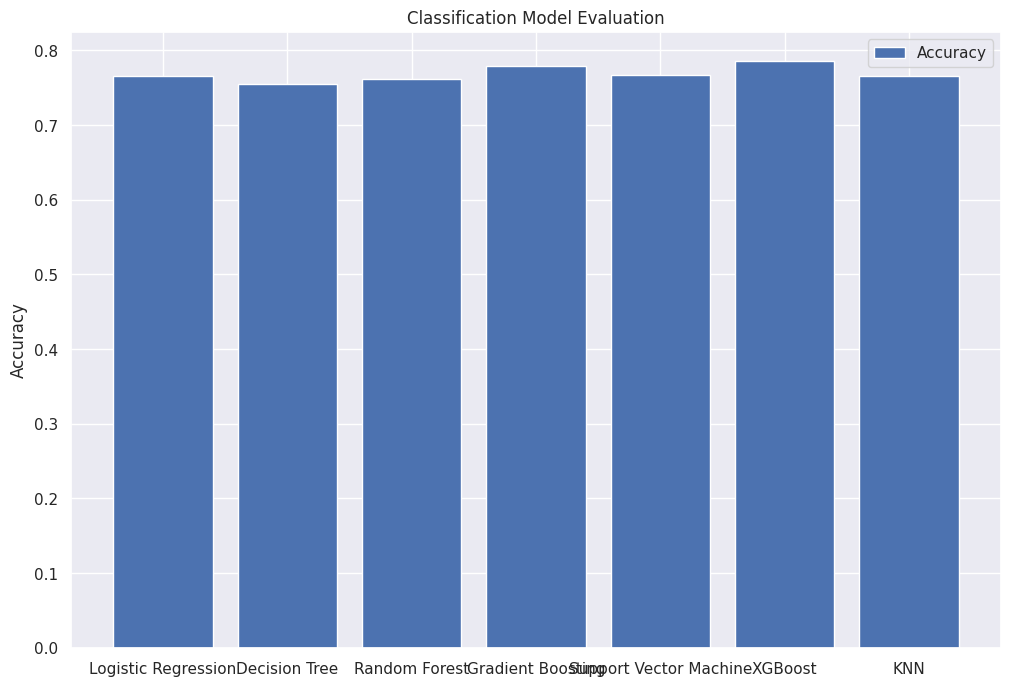

In [199]:
# Plot the results
fig, ax = plt.subplots(figsize=(12, 8))
accuracy_values = [result['Accuracy'] for result in classification_results.values()]
ax.bar(classification_results.keys(), accuracy_values, label='Accuracy')
ax.set_title('Classification Model Evaluation')
ax.set_ylabel('Accuracy')
ax.legend()
plt.show()

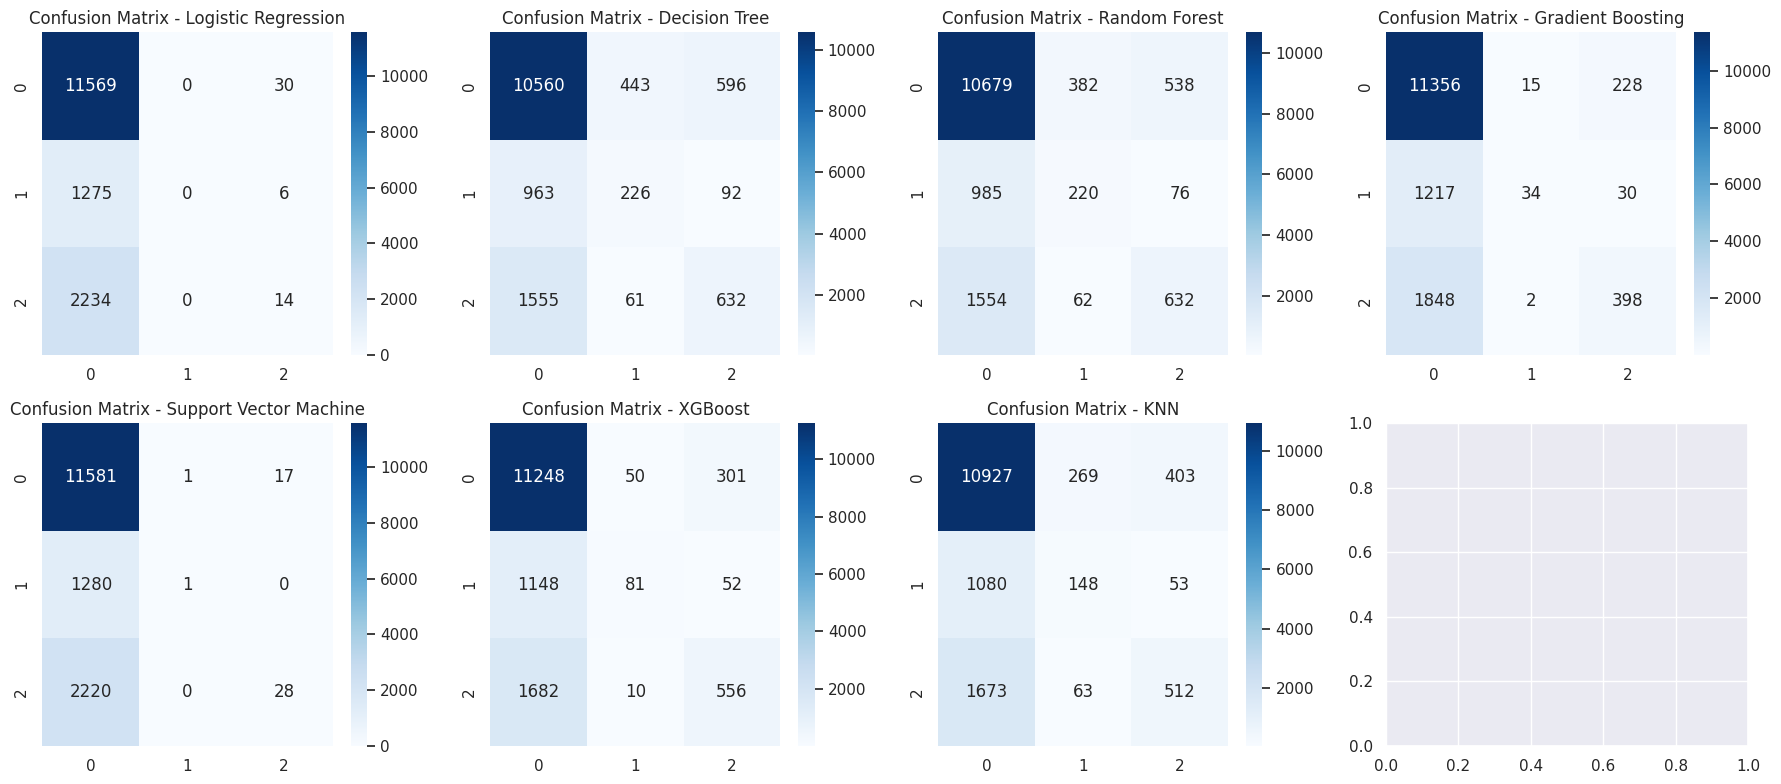

In [200]:
# Plot Confusion Matrices as Heatmaps
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 8))
axes = axes.ravel()

for i, (name, conf_matrix) in enumerate(conf_matrices.items()):
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix - {name}')

plt.tight_layout()
plt.show()

In [201]:
# Print Classification Reports
for name, result in classification_results.items():
    print(f"\n{name} Classification Report:")
    print(classification_report(y_cls_test, model.predict(X_cls_test)))


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.94      0.86     11599
           1       0.31      0.12      0.17      1281
           2       0.53      0.23      0.32      2248

    accuracy                           0.77     15128
   macro avg       0.55      0.43      0.45     15128
weighted avg       0.72      0.77      0.72     15128


Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.94      0.86     11599
           1       0.31      0.12      0.17      1281
           2       0.53      0.23      0.32      2248

    accuracy                           0.77     15128
   macro avg       0.55      0.43      0.45     15128
weighted avg       0.72      0.77      0.72     15128


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.94      0.86     11599
         